In [1]:
import os
os.chdir(r"C:\Users\bpa12\BME590\BME590_Project")
print(os.getcwd())

C:\Users\bpa12\BME590\BME590_Project


# gLV Fitting & Evaluation — Large Dataset (1000 communities, 25 species)

**Key design: per-community fitting.**
Each community has 8-12 of 25 species present. We fit one independent gLV
per community using only its present species. This gives a direct, meaningful
comparison: r_hat_c vs r1[c] and r2[c] for the same species in the same community.

**Pipeline:**
1. Imports + config
2. Core solver (log-space adaptive RK45)
3. Helper functions
4. Recover c2 weights (exact RNG replay)
5. Extract abundance zip
6. Load data + align ground truth
7. Per-community fitting (train + test)
8. Predict trajectories from fitted params
9. Full evaluation: trajectory fit, parameter recovery, output prediction
10. Regime-switch diagnosis (MSE vs time)
11. Community trajectory overlays
12. Parameter comparison plots
13. Output prediction + c2 weight comparison plots
14. Summary table

In [2]:
# =============================================================
# Cell 1 — Imports + Config
# =============================================================

from __future__ import annotations

import time
import warnings
from dataclasses import dataclass
from datetime import timedelta
from pathlib import Path
from typing import List, Tuple, Optional, Dict

import numpy as np
import pandas as pd

from scipy.optimize import least_squares
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt


# ---- Global numerical guards ----
X_FLOOR = 1e-12
Y_MIN   = -30.0
Y_MAX   =  30.0
Y_SOFT  =  20.0   # soft blowup threshold in log-space


@dataclass(frozen=True)
class Config:
    comm_col:       str   = "Comm_name"
    time_col:       str   = "Time"
    species_prefix: str   = "sp"

    train_frac: float = 0.8
    split_seed: int   = 42

    # Optimizer parameter bounds
    bounds_r: Tuple[float, float] = (-5.0, 5.0)
    bounds_A: Tuple[float, float] = (-15.0, 5.0)   # allow strongly negative diagonal
    lam_A:    float = 1e-4
    ridge_alpha: float = 1e-3

    # ODE solver tolerances
    rtol: float = 1e-4
    atol: float = 1e-7

    # Adaptive step controls
    dt_init: float = 0.05
    dt_min:  float = 1e-6
    dt_max:  float = 0.5
    max_steps_per_interval: int = 2000

    # Per-community fit budget
    # n_present ~ 10 species => 110 params; 500 evals is enough
    max_nfev_per_comm: int = 500


cfg = Config()


def _stamp(msg: str, t0: float) -> None:
    dt = timedelta(seconds=int(time.time() - t0))
    print(f"[{dt}] {msg}", flush=True)


def find_file(start: Path, rel: str) -> Path:
    p = start / rel
    if p.exists():
        return p
    target = Path(rel).name
    hits = sorted(start.rglob(target), key=lambda x: len(str(x)))
    if not hits:
        raise FileNotFoundError(f"Could not find {target!r} under {start.resolve()}")
    return hits[0]


repo_root = Path.cwd()
print("repo_root:", repo_root)

repo_root: C:\Users\bpa12\BME590\BME590_Project


In [3]:
# =============================================================
# Cell 2 — Core gLV solver (+ analytic sensitivities)
# =============================================================

def pack(r: np.ndarray, A: np.ndarray) -> np.ndarray:
    return np.concatenate([r.ravel(), A.ravel()])


def unpack(theta: np.ndarray, S: int) -> Tuple[np.ndarray, np.ndarray]:
    return theta[:S], theta[S:].reshape(S, S)


def glv_rhs_log(y: np.ndarray, r: np.ndarray, A: np.ndarray) -> np.ndarray:
    """Log-space gLV RHS: dy/dt = r + exp(y) @ A.T"""
    x = np.exp(np.clip(y, Y_MIN, Y_MAX))
    return r + x @ A.T


# Dormand-Prince RK45 coefficients (same as before)
_A_dp = [
    [],
    [1/5],
    [3/40, 9/40],
    [44/45, -56/15, 32/9],
    [19372/6561, -25360/2187, 64448/6561, -212/729],
    [9017/3168, -355/33, 46732/5247, 49/176, -5103/18656],
    [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84],
]
_B5 = np.array([35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0], dtype=float)
_B4 = np.array([5179/57600, 0, 7571/16695, 393/640, -92097/339200, 187/2100, 1/40], dtype=float)


def rk45_step_log(y, dt, r, A):
    k1 = glv_rhs_log(y, r, A)
    y2 = y + dt*(_A_dp[1][0]*k1)
    k2 = glv_rhs_log(y2, r, A)
    y3 = y + dt*(_A_dp[2][0]*k1 + _A_dp[2][1]*k2)
    k3 = glv_rhs_log(y3, r, A)
    y4 = y + dt*(_A_dp[3][0]*k1 + _A_dp[3][1]*k2 + _A_dp[3][2]*k3)
    k4 = glv_rhs_log(y4, r, A)
    y5s = y + dt*(_A_dp[4][0]*k1 + _A_dp[4][1]*k2 + _A_dp[4][2]*k3 + _A_dp[4][3]*k4)
    k5 = glv_rhs_log(y5s, r, A)
    y6 = y + dt*(_A_dp[5][0]*k1 + _A_dp[5][1]*k2 + _A_dp[5][2]*k3 +
                 _A_dp[5][3]*k4 + _A_dp[5][4]*k5)
    k6 = glv_rhs_log(y6, r, A)
    y7 = y + dt*(_A_dp[6][0]*k1 + _A_dp[6][1]*k2 + _A_dp[6][2]*k3 +
                 _A_dp[6][3]*k4 + _A_dp[6][4]*k5 + _A_dp[6][5]*k6)
    k7 = glv_rhs_log(y7, r, A)

    y5th = y + dt*(_B5[0]*k1 + _B5[2]*k3 + _B5[3]*k4 + _B5[4]*k5 + _B5[5]*k6)
    y4th = y + dt*(_B4[0]*k1 + _B4[2]*k3 + _B4[3]*k4 + _B4[4]*k5 + _B4[5]*k6 + _B4[6]*k7)
    return y5th, (y5th - y4th)


def integrate_log(
    x0: np.ndarray,          # (S,)
    timepoints: np.ndarray,  # (T,)
    r: np.ndarray,           # (S,)
    A: np.ndarray,           # (S, S)
) -> np.ndarray:             # (T, S)
    """
    Integrate log-space gLV using adaptive RK45 (same as before).
    Raises RuntimeError with graded blowup info on failure.
    """
    S = x0.shape[0]
    T = len(timepoints)

    y = np.log(np.maximum(x0, X_FLOOR))  # (S,)
    X_out = np.empty((T, S))
    X_out[0] = np.exp(np.clip(y, Y_MIN, Y_MAX))

    dt = float(cfg.dt_init)

    for ti in range(1, T):
        remaining = timepoints[ti] - timepoints[ti - 1]
        steps = 0
        while remaining > 1e-14:
            steps += 1
            if steps > cfg.max_steps_per_interval:
                raise RuntimeError(f"step_limit|max_y={float(np.max(y)):.2f}")

            dt_use = float(np.clip(min(dt, remaining), cfg.dt_min, cfg.dt_max))
            y_new, err = rk45_step_log(y, dt_use, r, A)

            scale = cfg.atol + cfg.rtol * np.maximum(np.abs(y), np.abs(y_new))
            e = float(np.max(np.abs(err) / (scale + 1e-30)))

            if e <= 1.0:
                y = y_new
                remaining -= dt_use
                fac = 2.0 if e == 0 else float(np.clip(0.9*(1/e)**0.2, 0.2, 2.5))
                dt = float(np.clip(dt_use*fac, cfg.dt_min, cfg.dt_max))
                max_y = float(np.max(y))
                if max_y > Y_SOFT:
                    overshoot = (max_y - Y_SOFT) / (Y_MAX - Y_SOFT + 1e-9)
                    raise RuntimeError(f"blowup|max_y={max_y:.2f}|overshoot={min(overshoot,1):.3f}")
            else:
                fac = float(np.clip(0.9*(1/e)**0.2, 0.1, 0.5))
                dt = float(np.clip(dt_use*fac, cfg.dt_min, cfg.dt_max))

        X_out[ti] = np.exp(np.clip(y, Y_MIN, Y_MAX))

    return X_out


def _rhs_aug_log(y: np.ndarray, dy_dp: np.ndarray, r: np.ndarray, A: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Augmented RHS for sensitivities wrt theta = [r (S), A (S*S)] in row-major.
    State is y = log x.

    dy/dt = r + x @ A.T
    d/dt(dy/dp) = J_y @ (dy/dp) + d f/dp

    where J_y[i,k] = x_k * A[i,k].
    """
    S = y.shape[0]
    x = np.exp(np.clip(y, Y_MIN, Y_MAX))

    # dy/dt
    dy = r + x @ A.T  # (S,)

    # J_y: (S,S) with entries A[i,k]*x_k (column-scaled A)
    Jy = A * x[None, :]

    # df/dp: first S columns are I (for r)
    # A-part: for each row i, columns i*S:(i+1)*S is x (for A[i, :])
    P = S + S*S
    df_dp = np.zeros((S, P), dtype=float)
    df_dp[:, :S] = np.eye(S)
    base = S
    for i in range(S):
        df_dp[i, base + i*S : base + (i+1)*S] = x  # (S,)

    d_dy_dp = Jy @ dy_dp + df_dp  # (S,P)
    return dy, d_dy_dp


def _rk45_step_aug_log(y, dy_dp, dt, r, A):
    """
    One RK45 step on augmented system (y, dy_dp), error estimate from y only.
    """
    dy1, dS1 = _rhs_aug_log(y, dy_dp, r, A)

    y2  = y     + dt*(_A_dp[1][0]*dy1)
    S2  = dy_dp + dt*(_A_dp[1][0]*dS1)
    dy2, dS2 = _rhs_aug_log(y2, S2, r, A)

    y3  = y     + dt*(_A_dp[2][0]*dy1 + _A_dp[2][1]*dy2)
    S3  = dy_dp + dt*(_A_dp[2][0]*dS1 + _A_dp[2][1]*dS2)
    dy3, dS3 = _rhs_aug_log(y3, S3, r, A)

    y4  = y     + dt*(_A_dp[3][0]*dy1 + _A_dp[3][1]*dy2 + _A_dp[3][2]*dy3)
    S4  = dy_dp + dt*(_A_dp[3][0]*dS1 + _A_dp[3][1]*dS2 + _A_dp[3][2]*dS3)
    dy4, dS4 = _rhs_aug_log(y4, S4, r, A)

    y5s = y     + dt*(_A_dp[4][0]*dy1 + _A_dp[4][1]*dy2 + _A_dp[4][2]*dy3 + _A_dp[4][3]*dy4)
    S5s = dy_dp + dt*(_A_dp[4][0]*dS1 + _A_dp[4][1]*dS2 + _A_dp[4][2]*dS3 + _A_dp[4][3]*dS4)
    dy5, dS5 = _rhs_aug_log(y5s, S5s, r, A)

    y6  = y     + dt*(_A_dp[5][0]*dy1 + _A_dp[5][1]*dy2 + _A_dp[5][2]*dy3 + _A_dp[5][3]*dy4 + _A_dp[5][4]*dy5)
    S6  = dy_dp + dt*(_A_dp[5][0]*dS1 + _A_dp[5][1]*dS2 + _A_dp[5][2]*dS3 + _A_dp[5][3]*dS4 + _A_dp[5][4]*dS5)
    dy6, dS6 = _rhs_aug_log(y6, S6, r, A)

    y7  = y     + dt*(_A_dp[6][0]*dy1 + _A_dp[6][1]*dy2 + _A_dp[6][2]*dy3 + _A_dp[6][3]*dy4 + _A_dp[6][4]*dy5 + _A_dp[6][5]*dy6)
    S7  = dy_dp + dt*(_A_dp[6][0]*dS1 + _A_dp[6][1]*dS2 + _A_dp[6][2]*dS3 + _A_dp[6][3]*dS4 + _A_dp[6][4]*dS5 + _A_dp[6][5]*dS6)
    dy7, dS7 = _rhs_aug_log(y7, S7, r, A)

    # 5th order update (matches integrate_log)
    y5th = y + dt*(_B5[0]*dy1 + _B5[2]*dy3 + _B5[3]*dy4 + _B5[4]*dy5 + _B5[5]*dy6)
    S5th = dy_dp + dt*(_B5[0]*dS1 + _B5[2]*dS3 + _B5[3]*dS4 + _B5[4]*dS5 + _B5[5]*dS6)

    # 4th order update for error estimate (y only)
    y4th = y + dt*(_B4[0]*dy1 + _B4[2]*dy3 + _B4[3]*dy4 + _B4[4]*dy5 + _B4[5]*dy6 + _B4[6]*dy7)

    err_y = (y5th - y4th)
    return y5th, S5th, err_y


def integrate_log_with_sens(
    x0: np.ndarray,          # (S,)
    timepoints: np.ndarray,  # (T,)
    r: np.ndarray,           # (S,)
    A: np.ndarray,           # (S, S)
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Integrate log-space gLV using the same adaptive RK45, and compute analytic sensitivities.

    Returns:
        X_out   (T, S)             predicted abundances
        dX_dth  (T, S, P)          P = S + S*S, derivative of X wrt theta=[r,A]
    Raises:
        RuntimeError with same grading as integrate_log on blowup/step limits.
    """
    S = x0.shape[0]
    T = len(timepoints)
    P = S + S*S

    y = np.log(np.maximum(x0, X_FLOOR))
    dy_dp = np.zeros((S, P), dtype=float)

    X_out  = np.empty((T, S), dtype=float)
    dX_dth = np.empty((T, S, P), dtype=float)

    x = np.exp(np.clip(y, Y_MIN, Y_MAX))
    X_out[0] = x
    # dx/dp = diag(x) * dy/dp
    dX_dth[0] = x[:, None] * dy_dp

    dt = float(cfg.dt_init)

    for ti in range(1, T):
        remaining = timepoints[ti] - timepoints[ti - 1]
        steps = 0
        while remaining > 1e-14:
            steps += 1
            if steps > cfg.max_steps_per_interval:
                raise RuntimeError(f"step_limit|max_y={float(np.max(y)):.2f}")

            dt_use = float(np.clip(min(dt, remaining), cfg.dt_min, cfg.dt_max))
            y_new, dy_dp_new, err = _rk45_step_aug_log(y, dy_dp, dt_use, r, A)

            scale = cfg.atol + cfg.rtol * np.maximum(np.abs(y), np.abs(y_new))
            e = float(np.max(np.abs(err) / (scale + 1e-30)))

            if e <= 1.0:
                y = y_new
                dy_dp = dy_dp_new
                remaining -= dt_use
                fac = 2.0 if e == 0 else float(np.clip(0.9*(1/e)**0.2, 0.2, 2.5))
                dt = float(np.clip(dt_use*fac, cfg.dt_min, cfg.dt_max))
                max_y = float(np.max(y))
                if max_y > Y_SOFT:
                    overshoot = (max_y - Y_SOFT) / (Y_MAX - Y_SOFT + 1e-9)
                    raise RuntimeError(f"blowup|max_y={max_y:.2f}|overshoot={min(overshoot,1):.3f}")
            else:
                fac = float(np.clip(0.9*(1/e)**0.2, 0.1, 0.5))
                dt = float(np.clip(dt_use*fac, cfg.dt_min, cfg.dt_max))

        x = np.exp(np.clip(y, Y_MIN, Y_MAX))
        X_out[ti] = x
        dX_dth[ti] = x[:, None] * dy_dp  # (S,P)

    return X_out, dX_dth


print("Cell 2 — solver (+ sensitivities) defined.")

Cell 2 — solver (+ sensitivities) defined.


In [18]:
# =============================================================
# Cell 3 — Helper functions
# =============================================================

def load_timeseries(path, comm_col, time_col, species_prefix):
    df = pd.read_csv(path)
    sp_cols = sorted(
        [c for c in df.columns if c.lower().startswith(species_prefix)],
        key=lambda x: int(x[len(species_prefix):]) if x[len(species_prefix):].isdigit() else x
    )
    df[time_col] = pd.to_numeric(df[time_col], errors="coerce")
    for c in sp_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=[comm_col, time_col] + sp_cols)
    df = df.sort_values([comm_col, time_col]).reset_index(drop=True)
    comms = df[comm_col].astype(str).unique().tolist()
    timepoints = np.sort(df[time_col].unique().astype(float))
    X_obs, x0 = [], []
    for comm in comms:
        d = df[df[comm_col].astype(str) == comm].sort_values(time_col)
        Xi = d[sp_cols].to_numpy(float)
        X_obs.append(Xi)
        x0.append(Xi[0])
    return df, comms, timepoints, np.stack(X_obs), np.stack(x0), sp_cols


def community_split(comms, train_frac, seed):
    rng = np.random.default_rng(seed)
    idx = rng.permutation(len(comms))
    n_train = int(np.floor(train_frac * len(comms)))
    return [comms[i] for i in idx[:n_train]], [comms[i] for i in idx[n_train:]]


def ridge_warm_start(x_obs_sub, timepoints, S_sub, lam=1e-3):
    """
    Fast closed-form warm-start for a SINGLE community's present-species subspace.
    x_obs_sub: (T, S_sub)
    Returns theta0 = pack(r0, A0) of length S_sub + S_sub^2.
    """
    T, S = x_obs_sub.shape
    rows_lhs, rows_rhs = [], []
    for ti in range(T - 1):
        dt  = timepoints[ti + 1] - timepoints[ti]
        x_t = x_obs_sub[ti]
        x_n = x_obs_sub[ti + 1]
        if np.all(x_t > X_FLOOR) and np.all(x_n > X_FLOOR):
            dlnx = (np.log(x_n) - np.log(x_t)) / dt
            rows_lhs.append(np.concatenate([[1.0], x_t]))
            rows_rhs.append(dlnx)
    if len(rows_lhs) < S + 1:
        r0 = np.full(S, 0.5)
        A0 = np.zeros((S, S))
        np.fill_diagonal(A0, -1.5)
        return pack(r0, A0)
    Phi = np.stack(rows_lhs)  # (N, S+1)
    Y   = np.stack(rows_rhs)  # (N, S)
    mdl = Ridge(alpha=lam, fit_intercept=False)
    mdl.fit(Phi, Y)
    r0 = np.clip(mdl.coef_[:, 0], cfg.bounds_r[0], cfg.bounds_r[1])
    A0 = np.clip(mdl.coef_[:, 1:], cfg.bounds_A[0], cfg.bounds_A[1])
    return pack(r0, A0)


def fit_community(
    x_obs: np.ndarray,          # (T, S_full)
    timepoints: np.ndarray,
    present_idx: np.ndarray,    # indices of present species in full space
    lam_A: float,
    max_nfev: int,
) -> Tuple[np.ndarray, np.ndarray, bool]:
    """
    Fit one gLV to one community in the present-species subspace using
    least_squares with an analytic Jacobian (via sensitivity integration).

    Returns:
        r_hat   (S_sub,)
        A_hat   (S_sub, S_sub)
        success bool
    """
    x_sub = x_obs[:, present_idx]         # (T, S)
    x0_sub = x_sub[0]                    # (S,)
    T, S = x_sub.shape
    P = S + S*S

    scale = np.maximum(x_sub.std(axis=0), 1e-6)

    lb = np.concatenate([np.full(S, cfg.bounds_r[0]), np.full(S*S, cfg.bounds_A[0])])
    ub = np.concatenate([np.full(S, cfg.bounds_r[1]), np.full(S*S, cfg.bounds_A[1])])

    theta0 = ridge_warm_start(x_sub, timepoints, S, cfg.ridge_alpha)

    sqrt_lam = float(np.sqrt(lam_A))
    reg_len = S*S
    resid_len = T*S + reg_len

    def fun(theta: np.ndarray) -> np.ndarray:
        r, A = unpack(theta, S)
        reg = sqrt_lam * A.ravel()
        try:
            x_pred = integrate_log(x0_sub, timepoints, r, A)  # (T,S)
        except RuntimeError as exc:
            msg = str(exc)
            if "blowup" in msg:
                try:
                    overshoot = float(msg.split("overshoot=")[1])
                except Exception:
                    overshoot = 1.0
                penalty = 10.0 * (1.0 + 9.0 * min(overshoot, 1.0))
            else:
                penalty = 50.0
            return np.full(resid_len, penalty, dtype=float)

        base = ((x_pred - x_sub) / scale).ravel()
        return np.concatenate([base, reg])

    def jac(theta: np.ndarray) -> np.ndarray:
        """
        Analytic Jacobian of residuals wrt theta.
        Shape: (T*S + S*S, S + S*S)
        """
        r, A = unpack(theta, S)
        J = np.zeros((resid_len, P), dtype=float)

        try:
            x_pred, dX_dth = integrate_log_with_sens(x0_sub, timepoints, r, A)  # (T,S), (T,S,P)
        except RuntimeError:
            # If solver fails, return a zero Jacobian; least_squares will rely on residual penalties.
            return J

        # base residuals: ((x_pred - x_sub)/scale).ravel()
        # d/dtheta base = (1/scale_s) * dX_dth[t,s,:]
        dbase = (dX_dth / scale[None, :, None]).reshape(T*S, P)
        J[:T*S, :] = dbase

        # reg residuals: sqrt(lam_A) * A.ravel()
        # derivative wrt A params is sqrt(lam_A) * I on the A-block
        J[T*S:, S:] = sqrt_lam * np.eye(S*S, dtype=float)
        return J

    try:
        opt = least_squares(
            fun,
            theta0,
            jac=jac,
            bounds=(lb, ub),
            method="trf",
            tr_solver="lsmr",
            x_scale="jac",
            loss="soft_l1",
            f_scale=1.0,
            max_nfev=max_nfev,
            ftol=1e-4, xtol=1e-4, gtol=1e-4,
            verbose=0,
        )
        r_hat, A_hat = unpack(opt.x, S)
        return r_hat, A_hat, True
    except Exception:
        r_hat, A_hat = unpack(theta0, S)
        return r_hat, A_hat, False


def predict_one(
    x0_full: np.ndarray,      # (S_full,)
    timepoints: np.ndarray,
    r_hat: np.ndarray,        # (S_sub,)
    A_hat: np.ndarray,        # (S_sub, S_sub)
    present_idx: np.ndarray,  # indices into full 25-species space
    S_full: int,
) -> np.ndarray:              # (T, S_full)
    """
    Forward-simulate fitted community, returning full 25-species trajectory.
    Absent species stay at zero.
    """
    T = len(timepoints)
    X_full = np.zeros((T, S_full))
    x0_sub = x0_full[present_idx]
    try:
        x_pred_sub = integrate_log(x0_sub, timepoints, r_hat, A_hat)  # (T, S_sub)
        X_full[:, present_idx] = x_pred_sub
    except RuntimeError:
        X_full[:] = np.nan
    return X_full


def auc_trapz(X, t):
    """X: (T, S) or (K, T, S). Integrates over time axis. Returns (..., S)."""
    dt = np.diff(t)
    if X.ndim == 2:
        return np.sum(0.5*(X[:-1]+X[1:]) * dt[:,None], axis=0)
    return np.sum(0.5*(X[:,:-1,:]+X[:,1:,:]) * dt[None,:,None], axis=1)


def fit_output_ridge(AUC, y_true, alpha=1e-3):
    ok  = ~np.isnan(AUC).any(axis=1) & ~np.isnan(y_true)
    mdl = Ridge(alpha=alpha, fit_intercept=True)
    mdl.fit(AUC[ok], y_true[ok])
    return mdl, mdl.coef_


def predict_and_evaluate(comms, AUC, ridge_mdl, gt_output, label):
    ok = ~np.isnan(AUC).any(axis=1) & ~np.isnan(gt_output)
    yhat = np.full(len(gt_output), np.nan)
    yhat[ok] = ridge_mdl.predict(AUC[ok])       # ← only predict on clean rows
    pear  = pearsonr(yhat[ok], gt_output[ok])[0]
    spear = spearmanr(yhat[ok], gt_output[ok])[0]
    r2    = r2_score(gt_output[ok], yhat[ok])
    print(f"[{label}] n_ok={ok.sum()}/{len(ok)} | pear={pear:.3f} | spear={spear:.3f} | R2={r2:.3f}")
    return dict(y_pred=yhat, y_true=gt_output, r2=r2, rmse=np.sqrt(np.mean((yhat[ok]-gt_output[ok])**2)),
                pearson=pear, valid=ok)

In [5]:
# =============================================================
# Cell 4 — Recover ground-truth c2 production weights
#
# Replays the exact RNG sequence from gen_data_1000com.ipynb Cell 2
# (which creates its own rng = np.random.default_rng(SEED=7)).
# Verified: n_producers and t_target match saved CSV exactly.
# =============================================================

t0_c2 = time.time()

npz1_path = find_file(repo_root, "gen_data_1000com/glv_positive_strong_complete/params_glv1_standard.npz")
npz2_path = find_file(repo_root, "gen_data_1000com/glv_positive_strong_complete/params_glv2.npz")
sum_path  = find_file(repo_root, "gen_data_1000com/glv_positive_strong_complete/production_output_summary.csv")

npz1 = np.load(npz1_path, allow_pickle=True)
npz2 = np.load(npz2_path, allow_pickle=True)
df_sum_gt = pd.read_csv(sum_path, dtype={"Comm_name": str})

mask_gt      = npz1["mask"].astype(bool)      # (1000, 25)
r1_gt        = npz1["r"].astype(float)         # (1000, 25)
A1_gt        = npz1["A"].astype(float)         # (1000, 25, 25)
r2_gt        = npz2["r2"].astype(float)        # (1000, 25)
A2_gt        = npz2["A2"].astype(float)        # (1000, 25, 25)
alpha_r_gt   = npz2["alpha_r"].astype(float)   # (1000, 25)
comm_names_gt = np.array([str(x) for x in npz1["comm_names"]], dtype=object)

N_COMM_GT, N_SPECIES_GT = r1_gt.shape
print(f"GT params: N_COMM={N_COMM_GT}, N_SPECIES={N_SPECIES_GT}")

# Generation constants (must match gen_data_1000com.ipynb Cell 2 exactly)
SEED_GEN        = 7
W_SIGMA         = 0.50;  W_MEAN_TARGET = 1.0
PRODUCER_K_LOW  = 2;     PRODUCER_K_HIGH = 5
C2_LOW, C2_HIGH = 0.2, 1.2
M0_JITTER_SIGMA = 0.05
TARGET_MEAN = 10.0; TARGET_SD = 1.2
TARGET_CLIP_LO = 7.0; TARGET_CLIP_HI = 13.0

# RNG replay
rng_c2 = np.random.default_rng(SEED_GEN)

# x0 block (consumed before main loop)
for c in range(N_COMM_GT):
    pres = np.where(mask_gt[c])[0]
    if pres.size:
        _ = rng_c2.dirichlet(np.full(pres.size, 2.0))

c2_gt = np.zeros((N_COMM_GT, N_SPECIES_GT), float)
w_gt  = np.zeros((N_COMM_GT, N_SPECIES_GT), float)
t_target_recovered = np.zeros(N_COMM_GT, float)

for c in range(N_COMM_GT):
    pres = np.where(mask_gt[c])[0]
    t_target_recovered[c] = float(np.clip(
        rng_c2.normal(TARGET_MEAN, TARGET_SD), TARGET_CLIP_LO, TARGET_CLIP_HI))
    w_sub = rng_c2.lognormal(0.0, W_SIGMA, size=pres.size)
    w_gt[c, pres] = w_sub * (W_MEAN_TARGET / np.mean(w_sub))
    k_prod   = int(rng_c2.integers(PRODUCER_K_LOW, min(PRODUCER_K_HIGH, pres.size)+1))
    prod_idx = rng_c2.choice(pres, size=k_prod, replace=False)
    c2_gt[c, prod_idx] = rng_c2.uniform(C2_LOW, C2_HIGH, size=k_prod)
    _ = rng_c2.lognormal(0.0, M0_JITTER_SIGMA)

# Verification
n_prod_rec = (c2_gt > 0).sum(axis=1)
assert np.all(n_prod_rec == df_sum_gt["n_producers"].values), "n_producers mismatch!"
assert np.allclose(t_target_recovered, df_sum_gt["t_target"].values, atol=1e-4), "t_target mismatch!"
print(f"c2 weights recovered and verified ({N_COMM_GT} communities).")
_stamp("c2 done.", t0_c2)

GT params: N_COMM=1000, N_SPECIES=25
c2 weights recovered and verified (1000 communities).
[0:00:00] c2 done.


In [6]:
# =============================================================
# Cell 5 — Extract abundance CSV from zip
# =============================================================

import zipfile

zip_candidates = list(repo_root.rglob("simulated_abundance_switch.csv.zip"))
if not zip_candidates:
    raise FileNotFoundError("simulated_abundance_switch.csv.zip not found")
zip_path = zip_candidates[0]
csv_extracted = zip_path.parent / "simulated_abundance_switch.csv"

if not csv_extracted.exists():
    print(f"Extracting {zip_path.name} ...")
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(zip_path.parent)
    print("Done.")
else:
    print("Already extracted.")
print("CSV:", csv_extracted)

Already extracted.
CSV: C:\Users\bpa12\BME590\BME590_Project\gen_data_1000com\glv_positive_strong_complete\simulated_abundance_switch.csv


In [7]:
# =============================================================
# Cell 6 — Load dataset, align ground truth, split
# =============================================================

t0_global = time.time()
_stamp("Loading abundance CSV...", t0_global)

_, comms_lg, tp_lg, X_lg, x0_lg, sp_cols_lg = load_timeseries(
    csv_extracted, cfg.comm_col, cfg.time_col, cfg.species_prefix
)
K_lg, T_lg, S_lg = X_lg.shape
_stamp(f"Loaded: K={K_lg}, T={T_lg}, S={S_lg}", t0_global)

# ---- Train/test split ----
train_comms, test_comms = community_split(comms_lg, cfg.train_frac, cfg.split_seed)
print(f"Train: {len(train_comms)}  |  Test: {len(test_comms)}")

comm_to_int = {c: i for i, c in enumerate(comms_lg)}
idx_tr = np.array([comm_to_int[c] for c in train_comms], dtype=np.int64)
idx_te = np.array([comm_to_int[c] for c in test_comms],  dtype=np.int64)

X_tr, x0_tr = X_lg[idx_tr], x0_lg[idx_tr]
X_te, x0_te = X_lg[idx_te], x0_lg[idx_te]

# ---- Align GT parameter arrays to CSV community ordering ----
gt_name_to_idx  = {str(n): i for i, n in enumerate(comm_names_gt)}
csv_order_in_gt = np.array([gt_name_to_idx[c] for c in comms_lg], dtype=np.int64)

r1_ord   = r1_gt[csv_order_in_gt]         # (K, 25)
A1_ord   = A1_gt[csv_order_in_gt]         # (K, 25, 25)
r2_ord   = r2_gt[csv_order_in_gt]
A2_ord   = A2_gt[csv_order_in_gt]
c2_ord   = c2_gt[csv_order_in_gt]         # (K, 25)
w_ord    = w_gt[csv_order_in_gt]
mask_ord = mask_gt[csv_order_in_gt]        # (K, 25) bool
alpha_r_ord = alpha_r_gt[csv_order_in_gt]

# Subset to train / test
r1_tr, r1_te = r1_ord[idx_tr], r1_ord[idx_te]
A1_tr, A1_te = A1_ord[idx_tr], A1_ord[idx_te]
r2_tr, r2_te = r2_ord[idx_tr], r2_ord[idx_te]
A2_tr, A2_te = A2_ord[idx_tr], A2_ord[idx_te]
c2_tr, c2_te = c2_ord[idx_tr], c2_ord[idx_te]
mask_tr, mask_te = mask_ord[idx_tr], mask_ord[idx_te]

gt_tswitch = df_sum_gt.set_index("Comm_name")["t_switch"].to_dict()
t_switch_all = np.array([gt_tswitch.get(c, np.nan) for c in comms_lg])
t_switch_tr  = t_switch_all[idx_tr]
t_switch_te  = t_switch_all[idx_te]

gt_output_map = df_sum_gt.set_index("Comm_name")["output"].to_dict()
y_true_all = np.array([gt_output_map.get(c, np.nan) for c in comms_lg])
y_tr_true  = y_true_all[idx_tr]
y_te_true  = y_true_all[idx_te]

print("Ground-truth arrays aligned. Ready to fit.")

[0:00:00] Loading abundance CSV...
[0:00:06] Loaded: K=1000, T=201, S=25
Train: 800  |  Test: 200
Ground-truth arrays aligned. Ready to fit.


In [8]:
# =============================================================
# Cell 7 — Per-community fitting (parallel + tqdm)
# =============================================================

import os
from joblib import Parallel, delayed
from tqdm.auto import tqdm


def _fit_one_community_job(x_obs_k, timepoints, pres, lam_A, max_nfev):
    # pres is an array of present indices into full space
    r_hat, A_hat, ok = fit_community(x_obs_k, timepoints, pres, lam_A, max_nfev)
    return pres, r_hat, A_hat, ok


def fit_all_communities(X_obs, mask, timepoints, lam_A, max_nfev, label, n_jobs=None, prefer="processes"):
    """
    Fit one gLV per community in its present-species subspace.

    Returns:
        r_hat_all  (K, S_full)          zeros for absent species
        A_hat_all  (K, S_full, S_full)  zeros for absent species pairs
        success    (K,) bool
    """
    K, T, S_full = X_obs.shape
    r_hat_all = np.zeros((K, S_full), dtype=float)
    A_hat_all = np.zeros((K, S_full, S_full), dtype=float)
    success   = np.zeros(K, dtype=bool)

    # Precompute present-species indices and keep them as small int arrays
    pres_list = [np.where(mask[k])[0].astype(int) for k in range(K)]

    if n_jobs is None:
        # Leave 1 core free by default
        n_jobs = max(1, (os.cpu_count() or 2) - 1)

    # Schedule jobs
    jobs = (delayed(_fit_one_community_job)(
        X_obs[k], timepoints, pres_list[k], lam_A, max_nfev
    ) for k in range(K))

    t0 = time.time()
    failures = 0

    # Run in parallel; update a single tqdm line as results stream back
    results = Parallel(n_jobs=n_jobs, prefer=prefer, batch_size=1)(
        tqdm(jobs, total=K, desc=f"[{label}] fitting", dynamic_ncols=True)
    )

    # Write back into full space
    for k, (pres, r_hat, A_hat, ok) in enumerate(results):
        r_hat_all[k, pres] = r_hat
        A_hat_all[np.ix_([k], pres, pres)] = A_hat[None]
        success[k] = ok

    elapsed = time.time() - t0
    print(f"[{label}] done. Successes: {success.sum()}/{K} | failures={K - success.sum()} | elapsed={elapsed:.1f}s")
    return r_hat_all, A_hat_all, success


print("Fitting train communities...")
r_hat_tr, A_hat_tr, success_tr = fit_all_communities(
    X_tr, mask_tr, tp_lg, cfg.lam_A, cfg.max_nfev_per_comm, "Train"
)

print("\nFitting test communities...")
r_hat_te, A_hat_te, success_te = fit_all_communities(
    X_te, mask_te, tp_lg, cfg.lam_A, cfg.max_nfev_per_comm, "Test"
)

print("\nSample r_hat (comm 0, present species):",
      r_hat_tr[0, mask_tr[0]].round(4))
print("True r1    (comm 0, present species):",
      r1_tr[0, mask_tr[0]].round(4))

C:\Users\bpa12\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fitting train communities...


[Train] fitting: 100%|██████████| 800/800 [02:09<00:00,  6.19it/s]


[Train] done. Successes: 800/800 | failures=0 | elapsed=141.1s

Fitting test communities...


[Test] fitting: 100%|██████████| 200/200 [00:22<00:00,  8.78it/s]


[Test] done. Successes: 200/200 | failures=0 | elapsed=36.1s

Sample r_hat (comm 0, present species): [0.8744 0.5096 0.9796 0.5093 0.9271 0.924  0.7947 0.7071 0.5305 0.723
 0.5531]
True r1    (comm 0, present species): [0.884  0.5068 0.9821 0.5216 0.9214 0.9267 0.7731 0.7128 0.5203 0.7117
 0.5744]


In [15]:
# =============================================================
# Cell 8 — Predict trajectories + compute AUC
# =============================================================

def predict_all_communities(x0_all, mask_all, r_hat_all, A_hat_all, timepoints, S_full):
    """Forward-simulate each community using its fitted parameters."""
    K = x0_all.shape[0]
    T = len(timepoints)
    X_pred = np.full((K, T, S_full), np.nan)
    for k in range(K):
        pres = np.where(mask_all[k])[0]
        X_full = predict_one(
            x0_all[k], timepoints,
            r_hat_all[k, pres],
            A_hat_all[k][np.ix_(pres, pres)],
            pres, S_full
        )
        X_pred[k] = X_full
    n_failed = np.isnan(X_pred[:, 1, 0]).sum()
    if n_failed:
        print(f"  {n_failed}/{K} communities failed prediction (NaN).")
    return X_pred


print("Predicting train trajectories...")
Xpred_tr = predict_all_communities(x0_tr, mask_tr, r_hat_tr, A_hat_tr, tp_lg, S_lg)

print("Predicting test trajectories...")
Xpred_te = predict_all_communities(x0_te, mask_te, r_hat_te, A_hat_te, tp_lg, S_lg)

# Per-community AUC from predicted and observed trajectories
AUC_pred_tr = auc_trapz(Xpred_tr, tp_lg)   # (K_tr, 25)
AUC_pred_te = auc_trapz(Xpred_te, tp_lg)
AUC_obs_tr  = auc_trapz(X_tr,     tp_lg)   # oracle
AUC_obs_te  = auc_trapz(X_te,     tp_lg)

# Ridge: output ~ AUC_predicted
print("\nFitting Ridge: output ~ predicted AUC...")
ridge_mdl, ridge_coef = fit_output_ridge(AUC_pred_tr, y_tr_true, cfg.ridge_alpha)

# Oracle Ridge: output ~ observed AUC (upper bound)
print("Fitting Ridge: output ~ observed AUC (oracle)...")
ridge_obs_mdl, ridge_obs_coef = fit_output_ridge(AUC_obs_tr, y_tr_true, cfg.ridge_alpha)

# Direct AUC estimate: output = sum(c2_c * AUC_pred_c) per community
# (no Ridge needed — use known c2 weights directly)
output_direct_pred_tr = np.array([
    np.sum(c2_tr[k] * AUC_pred_tr[k]) for k in range(len(train_comms))
])
output_direct_pred_te = np.array([
    np.sum(c2_te[k] * AUC_pred_te[k]) for k in range(len(test_comms))
])
output_direct_obs_tr = np.array([
    np.sum(c2_tr[k] * AUC_obs_tr[k]) for k in range(len(train_comms))
])
output_direct_obs_te = np.array([
    np.sum(c2_te[k] * AUC_obs_te[k]) for k in range(len(test_comms))
])

print("AUC and output computation done.")

Predicting train trajectories...
  59/800 communities failed prediction (NaN).
Predicting test trajectories...
  17/200 communities failed prediction (NaN).

Fitting Ridge: output ~ predicted AUC...
Fitting Ridge: output ~ observed AUC (oracle)...
AUC and output computation done.


In [19]:
# =============================================================
# Cell 9 — Full evaluation: all metrics
# =============================================================

# ─────────────────────────────────────────────────────────────
# LEVEL 1: Trajectory Fit Quality
# ─────────────────────────────────────────────────────────────

def trajectory_metrics(X_obs, X_pred, mask, label):
    """
    Per-community trajectory fit metrics.
    Metrics computed only on PRESENT species (mask=True) to avoid
    inflating R² with trivially-zero absent species.
    """
    K, T, S = X_obs.shape
    valid = ~np.isnan(X_pred[:, 1, 0])  # communities with valid predictions

    rmse_c   = np.full(K, np.nan)
    mae_c    = np.full(K, np.nan)
    r2_c     = np.full(K, np.nan)
    rmse_log_c = np.full(K, np.nan)
    r2_log_c   = np.full(K, np.nan)

    for k in range(K):
        if not valid[k]:
            continue
        pres = np.where(mask[k])[0]
        xo = X_obs[k][:, pres].ravel()   # present species only
        xp = X_pred[k][:, pres].ravel()

        res = xp - xo
        rmse_c[k] = np.sqrt(np.mean(res**2))
        mae_c[k]  = np.mean(np.abs(res))
        ss_res = np.sum(res**2)
        ss_tot = np.sum((xo - xo.mean())**2)
        r2_c[k] = 1.0 - ss_res / (ss_tot + 1e-30)

        pos = (xo > X_FLOOR) & (xp > X_FLOOR)
        if pos.sum() > 1:
            lo, lp = np.log(xo[pos]), np.log(xp[pos])
            lres = lp - lo
            rmse_log_c[k] = np.sqrt(np.mean(lres**2))
            ss_res_l = np.sum(lres**2)
            ss_tot_l = np.sum((lo - lo.mean())**2)
            r2_log_c[k] = 1.0 - ss_res_l / (ss_tot_l + 1e-30)

    print(f"\n── Trajectory fit [{label}] ──")
    print(f"  Valid: {valid.sum()}/{K}")
    print(f"  RMSE        : mean={np.nanmean(rmse_c):.4f}  median={np.nanmedian(rmse_c):.4f}")
    print(f"  MAE         : mean={np.nanmean(mae_c):.4f}")
    print(f"  R² (abund)  : mean={np.nanmean(r2_c):.4f}  median={np.nanmedian(r2_c):.4f}")
    print(f"  RMSE log    : mean={np.nanmean(rmse_log_c):.4f}")
    print(f"  R² log      : mean={np.nanmean(r2_log_c):.4f}  median={np.nanmedian(r2_log_c):.4f}")

    return dict(rmse=rmse_c, mae=mae_c, r2=r2_c,
                rmse_log=rmse_log_c, r2_log=r2_log_c, valid=valid)


traj_tr = trajectory_metrics(X_tr, Xpred_tr, mask_tr, "Train")
traj_te = trajectory_metrics(X_te, Xpred_te, mask_te, "Test")


# ─────────────────────────────────────────────────────────────
# LEVEL 2: Parameter Recovery (per-community, present species)
# ─────────────────────────────────────────────────────────────

def parameter_recovery_metrics(r_hat_all, A_hat_all, r1_all, A1_all,
                                r2_all, A2_all, mask_all, t_switch, t_total, label):
    """
    Per-community parameter recovery.
    All comparisons made on PRESENT species only, pooled across communities.

    r_hat_c should land between r1_c and r2_c since the fit sees
    a trajectory that switches regime at t_switch.
    We compute:
      - r_hat vs r1 (should be biased high since r1 > r2)
      - r_hat vs r2 (should be biased low)
      - r_hat vs blended r (frac1*r1 + frac2*r2 per community)
      - Same for A diagonal and off-diagonal
    """
    K = r_hat_all.shape[0]

    # Per-community time fractions
    frac2_c = np.clip(t_switch / t_total, 0, 1)  # fraction of time in regime 2
    frac1_c = 1.0 - frac2_c

    # Pool all present-species values across communities
    r_hat_pool, r1_pool, r2_pool, rblend_pool = [], [], [], []
    a_hat_pool, a1_pool, a2_pool, ablend_pool = [], [], [], []
    adiag_hat, adiag1, adiag_blend = [], [], []

    for k in range(K):
        pres = np.where(mask_all[k])[0]
        f1, f2 = frac1_c[k], frac2_c[k]

        # r vectors (present species)
        rh = r_hat_all[k, pres]
        r1 = r1_all[k, pres]
        r2 = r2_all[k, pres]
        rb = f1*r1 + f2*r2
        r_hat_pool.extend(rh); r1_pool.extend(r1)
        r2_pool.extend(r2);    rblend_pool.extend(rb)

        # A matrices (present x present subspace)
        Ah = A_hat_all[k][np.ix_(pres, pres)]
        A1 = A1_all[k][np.ix_(pres, pres)]
        A2 = A2_all[k][np.ix_(pres, pres)]
        Ab = f1*A1 + f2*A2

        # Diagonal (self-limitation)
        adiag_hat.extend(np.diag(Ah))
        adiag1.extend(np.diag(A1))
        adiag_blend.extend(np.diag(Ab))

        # Off-diagonal
        off = ~np.eye(len(pres), dtype=bool)
        if off.sum() > 0:
            a_hat_pool.extend(Ah[off]); a1_pool.extend(A1[off])
            a2_pool.extend(A2[off]);    ablend_pool.extend(Ab[off])

    r_hat_pool = np.array(r_hat_pool)
    r1_pool    = np.array(r1_pool)
    r2_pool    = np.array(r2_pool)
    rblend_pool = np.array(rblend_pool)
    a_hat_pool  = np.array(a_hat_pool)
    a1_pool     = np.array(a1_pool)
    ablend_pool = np.array(ablend_pool)
    adiag_hat   = np.array(adiag_hat)
    adiag1      = np.array(adiag1)
    adiag_blend = np.array(adiag_blend)

    def _stats(a, b, name):
        rmse = np.sqrt(np.mean((a-b)**2))
        mae  = np.mean(np.abs(a-b))
        bias = np.mean(a-b)
        corr, _ = pearsonr(a, b) if len(a) > 1 else (np.nan, np.nan)
        print(f"  {name:<35s} RMSE={rmse:.4f}  MAE={mae:.4f}  bias={bias:+.4f}  r={corr:.4f}")
        return dict(rmse=rmse, mae=mae, bias=bias, corr=corr)

    print(f"\n── Parameter recovery [{label}] ──")
    mean_f2 = np.nanmean(frac2_c)
    print(f"  Mean time fractions: frac_r1={1-mean_f2:.3f}  frac_r2={mean_f2:.3f}")
    print(f"  Total pooled r values: {len(r_hat_pool)}")
    print(f"  Total pooled off-diag A values: {len(a_hat_pool)}")

    out = {}
    print("  (growth rates r — present species pooled)")
    out["r_vs_r1"]    = _stats(r_hat_pool, r1_pool,    "r_hat vs r1")
    out["r_vs_r2"]    = _stats(r_hat_pool, r2_pool,    "r_hat vs r2")
    out["r_vs_blend"] = _stats(r_hat_pool, rblend_pool, "r_hat vs blend_r")

    print("  (off-diagonal A — present pairs pooled)")
    out["A_off_vs_A1"]    = _stats(a_hat_pool, a1_pool,    "A_hat offdiag vs A1")
    out["A_off_vs_blend"] = _stats(a_hat_pool, ablend_pool, "A_hat offdiag vs blend")

    print("  (diagonal A — self-limitation)")
    out["Adiag_vs_A1"]    = _stats(adiag_hat, adiag1,      "Adiag vs A1")
    out["Adiag_vs_blend"] = _stats(adiag_hat, adiag_blend,  "Adiag vs blend")

    # Sign agreement on off-diagonal
    sa_A1    = np.mean(np.sign(a_hat_pool) == np.sign(a1_pool))
    sa_blend = np.mean(np.sign(a_hat_pool) == np.sign(ablend_pool))
    print(f"  Sign agreement off-diag A vs A1   : {sa_A1:.3f}")
    print(f"  Sign agreement off-diag A vs blend: {sa_blend:.3f}")

    # Spectral: per-community max real eigenvalue of A_hat vs A1 vs blend
    eigs_hat, eigs_A1, eigs_blend = [], [], []
    for k in range(K):
        pres = np.where(mask_all[k])[0]
        f1, f2 = frac1_c[k], frac2_c[k]
        Ah = A_hat_all[k][np.ix_(pres, pres)]
        A1m = A1_all[k][np.ix_(pres, pres)]
        A2m = A2_all[k][np.ix_(pres, pres)]
        Ab  = f1*A1m + f2*A2m
        eigs_hat.append(np.max(np.real(np.linalg.eigvals(Ah))))
        eigs_A1.append(np.max(np.real(np.linalg.eigvals(A1m))))
        eigs_blend.append(np.max(np.real(np.linalg.eigvals(Ab))))
    eigs_hat   = np.array(eigs_hat)
    eigs_A1    = np.array(eigs_A1)
    eigs_blend = np.array(eigs_blend)
    print(f"  Max eigenvalue A_hat  : mean={eigs_hat.mean():.4f}  median={np.median(eigs_hat):.4f}")
    print(f"  Max eigenvalue A1     : mean={eigs_A1.mean():.4f}  median={np.median(eigs_A1):.4f}")
    print(f"  Max eigenvalue blend A: mean={eigs_blend.mean():.4f}  median={np.median(eigs_blend):.4f}")

    out.update(dict(
        r_hat_pool=r_hat_pool, r1_pool=r1_pool, r2_pool=r2_pool, rblend_pool=rblend_pool,
        a_hat_pool=a_hat_pool, a1_pool=a1_pool, ablend_pool=ablend_pool,
        adiag_hat=adiag_hat, adiag1=adiag1, adiag_blend=adiag_blend,
        sa_A1=sa_A1, sa_blend=sa_blend,
        eigs_hat=eigs_hat, eigs_A1=eigs_A1, eigs_blend=eigs_blend,
        frac1_c=frac1_c, frac2_c=frac2_c,
    ))
    return out


param_tr = parameter_recovery_metrics(
    r_hat_tr, A_hat_tr, r1_tr, A1_tr, r2_tr, A2_tr,
    mask_tr, t_switch_tr, tp_lg[-1] - tp_lg[0], "Train"
)
param_te = parameter_recovery_metrics(
    r_hat_te, A_hat_te, r1_te, A1_te, r2_te, A2_te,
    mask_te, t_switch_te, tp_lg[-1] - tp_lg[0], "Test"
)


# ─────────────────────────────────────────────────────────────
# LEVEL 3: Output (P_final) Prediction
# ─────────────────────────────────────────────────────────────

print("\n── Output prediction ──")

# Method A: Ridge on predicted AUC (fitted model)
eval_tr_pred = predict_and_evaluate(
    train_comms, AUC_pred_tr, ridge_mdl, y_tr_true,
    "Train — Ridge(predicted AUC)"
)
eval_te_pred = predict_and_evaluate(
    test_comms, AUC_pred_te, ridge_mdl, y_te_true,
    "Test  — Ridge(predicted AUC)"
)
# Method B: Ridge on observed AUC (oracle ceiling)
eval_tr_obs = predict_and_evaluate(
    train_comms, AUC_obs_tr, ridge_obs_mdl, y_tr_true,
    "Train — Ridge(observed AUC, oracle)"
)
eval_te_obs = predict_and_evaluate(
    test_comms, AUC_obs_te, ridge_obs_mdl, y_te_true,
    "Test  — Ridge(observed AUC, oracle)"
)

# Method C: Direct c2 dot product (known weights, predicted AUC)
def _eval_direct(y_pred, y_true, label):
    ok = ~np.isnan(y_pred) & ~np.isnan(y_true)
    r2   = r2_score(y_true[ok], y_pred[ok]) if ok.sum() > 1 else np.nan
    rmse = np.sqrt(np.mean((y_pred[ok]-y_true[ok])**2))
    corr, _ = pearsonr(y_true[ok], y_pred[ok]) if ok.sum() > 1 else (np.nan, np.nan)
    print(f"[{label}] n={ok.sum()}  R²={r2:.4f}  RMSE={rmse:.4f}  r={corr:.4f}")
    return dict(y_pred=y_pred, y_true=y_true, r2=r2, rmse=rmse, pearson=corr, valid=ok)

eval_tr_direct_pred = _eval_direct(output_direct_pred_tr, y_tr_true,
                                    "Train — c2@AUC_pred (direct, known c2)")
eval_te_direct_pred = _eval_direct(output_direct_pred_te, y_te_true,
                                    "Test  — c2@AUC_pred (direct, known c2)")
eval_tr_direct_obs  = _eval_direct(output_direct_obs_tr, y_tr_true,
                                    "Train — c2@AUC_obs  (oracle ceiling)")
eval_te_direct_obs  = _eval_direct(output_direct_obs_te, y_te_true,
                                    "Test  — c2@AUC_obs  (oracle ceiling)")


# ─────────────────────────────────────────────────────────────
# c2 weight recovery: Ridge coef vs true c2
# ─────────────────────────────────────────────────────────────

mean_c2_all = c2_ord.mean(axis=0)   # (25,) mean over all 1000 communities

corr_c2_pred, _  = pearsonr(ridge_coef, mean_c2_all)
corr_c2_obs, _   = pearsonr(ridge_obs_coef, mean_c2_all)
spear_c2_pred, _ = spearmanr(ridge_coef, mean_c2_all)
spear_c2_obs, _  = spearmanr(ridge_obs_coef, mean_c2_all)

print("\n── c2 weight recovery ──")
print(f"  Ridge(pred AUC) coef vs mean_c2: Pearson r={corr_c2_pred:.4f}  Spearman rho={spear_c2_pred:.4f}")
print(f"  Ridge(obs AUC)  coef vs mean_c2: Pearson r={corr_c2_obs:.4f}  Spearman rho={spear_c2_obs:.4f}")

# Top-k accuracy: among species with highest ridge coef, what fraction are actual producers?
# Use only species that are producers in at least 10% of communities for a meaningful threshold
prod_freq = (c2_ord > 0).mean(axis=0)   # fraction of communities where each species is a producer
is_meaningful_producer = prod_freq >= 0.10
n_mp = is_meaningful_producer.sum()
topk_pred = is_meaningful_producer[np.argsort(-ridge_coef)[:n_mp]].mean()
topk_obs  = is_meaningful_producer[np.argsort(-ridge_obs_coef)[:n_mp]].mean()
print(f"  Top-{n_mp} accuracy (meaningful producers, pred): {topk_pred:.3f}")
print(f"  Top-{n_mp} accuracy (meaningful producers, obs) : {topk_obs:.3f}")

print("\nAll metrics computed.")


── Trajectory fit [Train] ──
  Valid: 741/800
  RMSE        : mean=0.0351  median=0.0038
  MAE         : mean=0.0136
  R² (abund)  : mean=0.6527  median=0.9993
  RMSE log    : mean=0.1274
  R² log      : mean=0.9416  median=0.9996

── Trajectory fit [Test] ──
  Valid: 183/200
  RMSE        : mean=0.0194  median=0.0038
  MAE         : mean=0.0065
  R² (abund)  : mean=0.8054  median=0.9992
  RMSE log    : mean=0.1254
  R² log      : mean=0.9758  median=0.9996

── Parameter recovery [Train] ──
  Mean time fractions: frac_r1=0.499  frac_r2=0.501
  Total pooled r values: 8010
  Total pooled off-diag A values: 73738
  (growth rates r — present species pooled)
  r_hat vs r1                         RMSE=0.0850  MAE=0.0219  bias=+0.0061  r=0.9022
  r_hat vs r2                         RMSE=0.3923  MAE=0.3590  bias=+0.3570  r=0.5729
  r_hat vs blend_r                    RMSE=0.2141  MAE=0.1842  bias=+0.1819  r=0.8241
  (off-diagonal A — present pairs pooled)
  A_hat offdiag vs A1                

In [20]:
# =============================================================
# Diagnostic: top-k producer accuracy check
# =============================================================

prod_freq = (c2_ord > 0).mean(axis=0)   # fraction of communities where each species is a producer

print("Per-species producer frequency (fraction of 1000 communities):")
print(f"{'Species':<10} {'Prod freq':>10} {'Mean c2':>10} {'Meaningful?':>12}")
print("-" * 46)
for i, sp in enumerate(sp_cols_lg):
    flag = "YES" if prod_freq[i] >= 0.10 else "no"
    print(f"{sp:<10} {prod_freq[i]:>10.3f} {mean_c2_all[i]:>10.4f} {flag:>12}")

n_meaningful = (prod_freq >= 0.10).sum()
print(f"\nn_meaningful_producers (freq >= 0.10): {n_meaningful} / {len(prod_freq)}")
print(f"\nIf n_meaningful = {n_meaningful} = S = {S_lg}, then top-{n_meaningful} of {S_lg} = trivially 1.0")
print(f"\nProducer frequency range: [{prod_freq.min():.3f}, {prod_freq.max():.3f}]")
print(f"Species with freq < 0.10: {(prod_freq < 0.10).sum()}")
print(f"Species with freq = 0:    {(prod_freq == 0.0).sum()}")

Per-species producer frequency (fraction of 1000 communities):
Species     Prod freq    Mean c2  Meaningful?
----------------------------------------------
sp1             0.132     0.0901          YES
sp2             0.136     0.1019          YES
sp3             0.128     0.0986          YES
sp4             0.167     0.1126          YES
sp5             0.148     0.1063          YES
sp6             0.149     0.1061          YES
sp7             0.134     0.0940          YES
sp8             0.157     0.1146          YES
sp9             0.158     0.1132          YES
sp10            0.140     0.1001          YES
sp11            0.145     0.1038          YES
sp12            0.131     0.0881          YES
sp13            0.142     0.1075          YES
sp14            0.126     0.0858          YES
sp15            0.152     0.1012          YES
sp16            0.141     0.0972          YES
sp17            0.143     0.1028          YES
sp18            0.138     0.0975          YES
sp19            

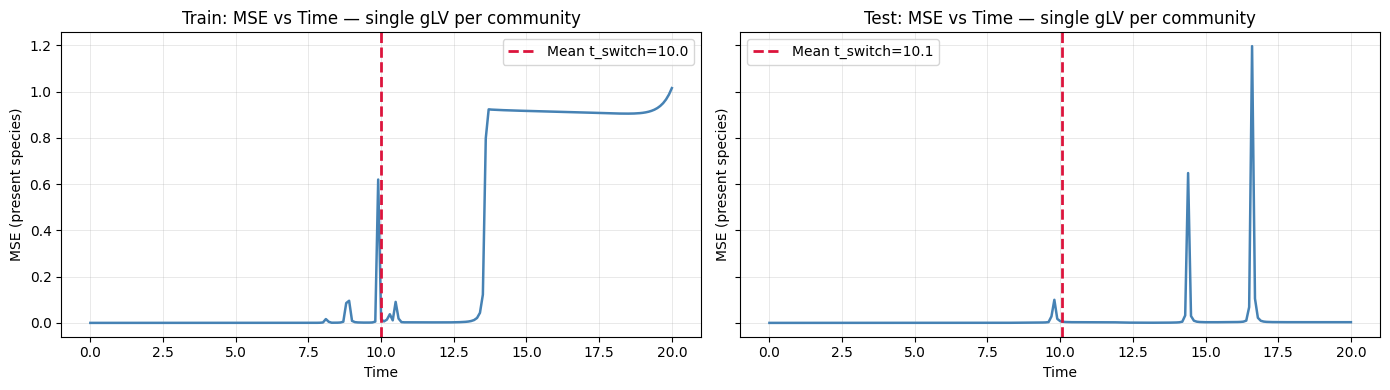

In [21]:
# =============================================================
# Cell 10 — Regime-switch diagnosis: MSE vs time
# =============================================================

def mse_vs_time(X_obs, X_pred, mask, valid):
    """Mean squared error per timepoint, averaged over present species and valid communities."""
    K, T, S = X_obs.shape
    mse_t = np.zeros(T)
    count = 0
    for k in range(K):
        if not valid[k]:
            continue
        pres = np.where(mask[k])[0]
        diff = X_pred[k][:, pres] - X_obs[k][:, pres]  # (T, n_pres)
        mse_t += np.mean(diff**2, axis=1)
        count += 1
    return mse_t / max(count, 1)


mse_t_tr = mse_vs_time(X_tr, Xpred_tr, mask_tr, traj_tr["valid"])
mse_t_te = mse_vs_time(X_te, Xpred_te, mask_te, traj_te["valid"])

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
for ax, mse_t, t_sw, label in [
    (axes[0], mse_t_tr, np.nanmean(t_switch_tr), "Train"),
    (axes[1], mse_t_te, np.nanmean(t_switch_te), "Test"),
]:
    ax.plot(tp_lg, mse_t, lw=1.8, color="steelblue")
    ax.axvline(t_sw, color="crimson", ls="--", lw=2,
               label=f"Mean t_switch={t_sw:.1f}")
    ax.set_xlabel("Time")
    ax.set_ylabel("MSE (present species)")
    ax.set_title(f"{label}: MSE vs Time — single gLV per community")
    ax.legend()
    ax.grid(True, lw=0.4, alpha=0.5)
plt.tight_layout()
plt.show()

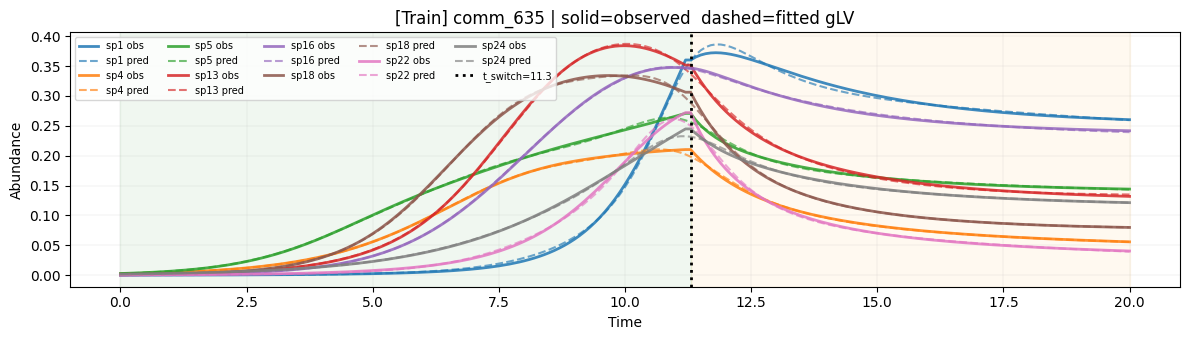

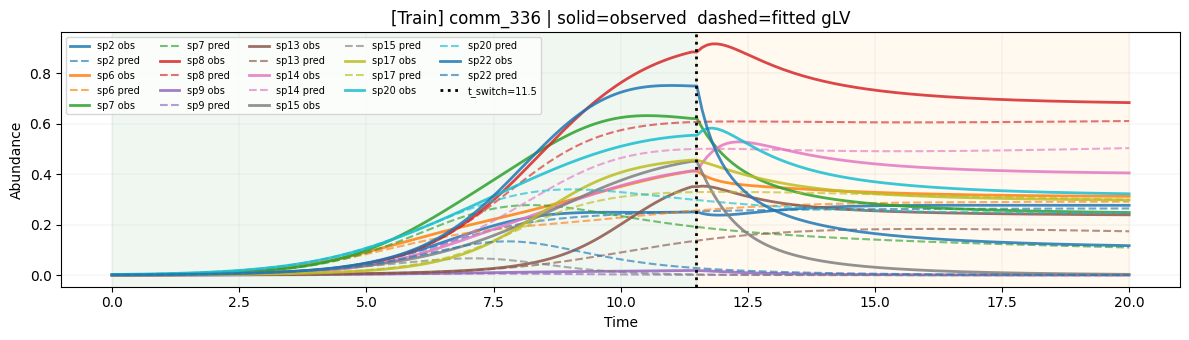

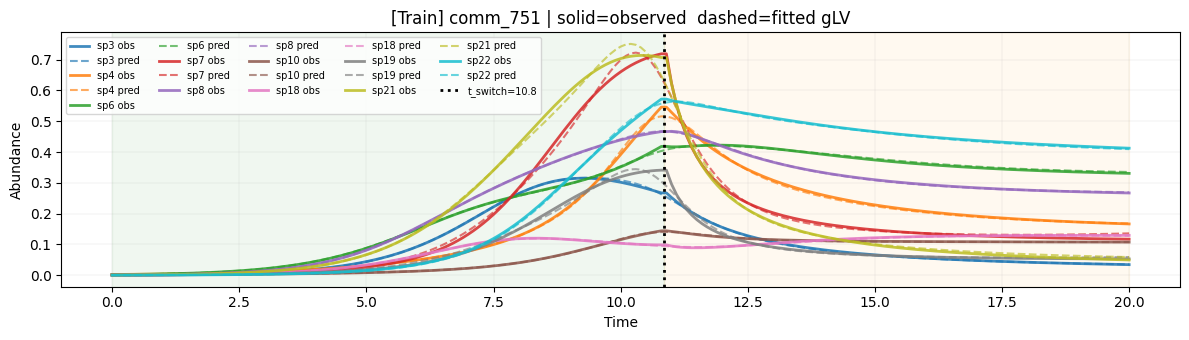

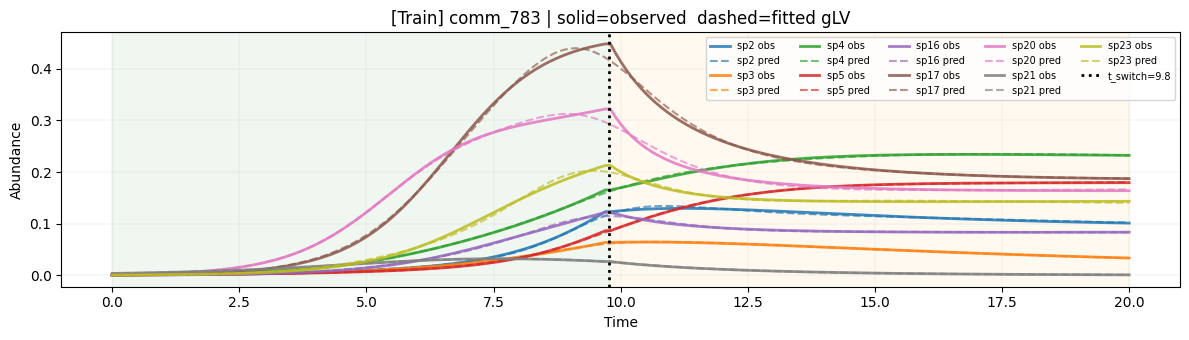

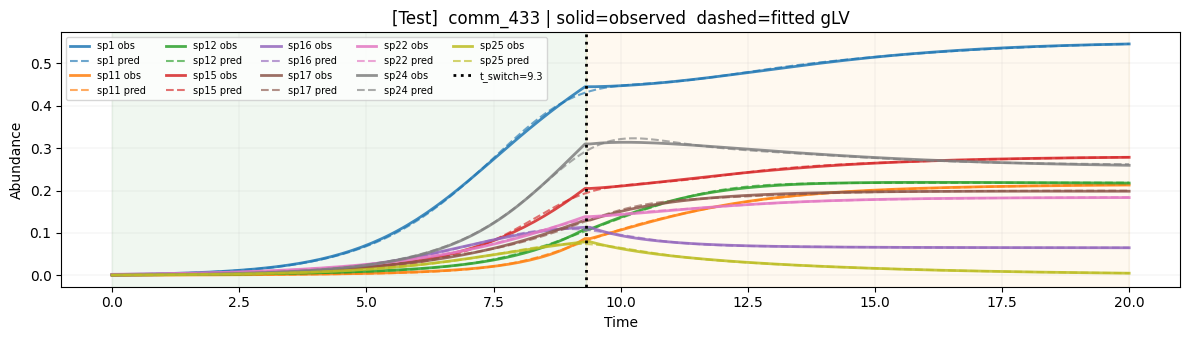

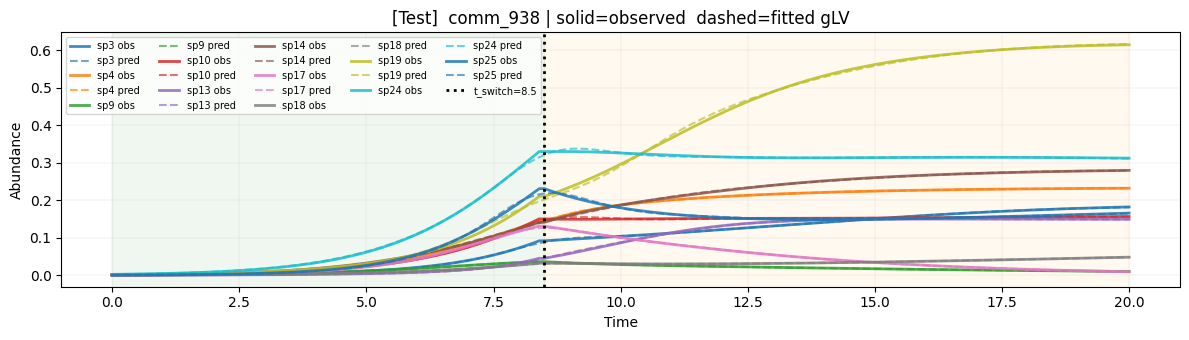

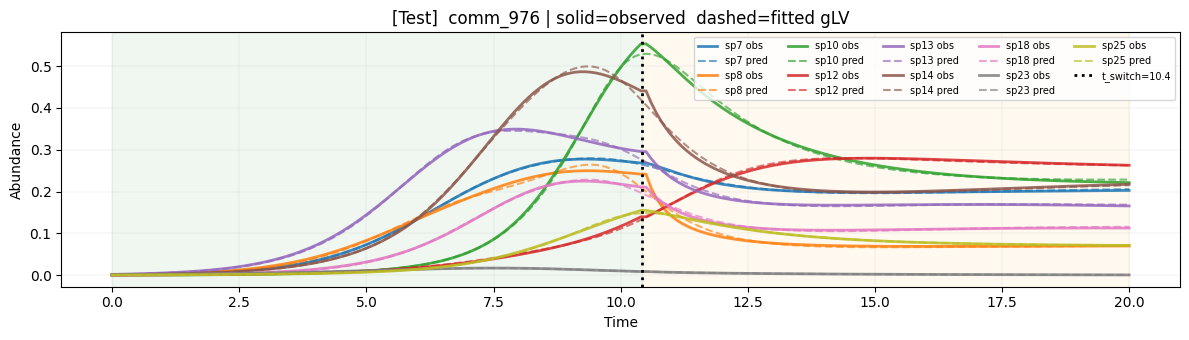

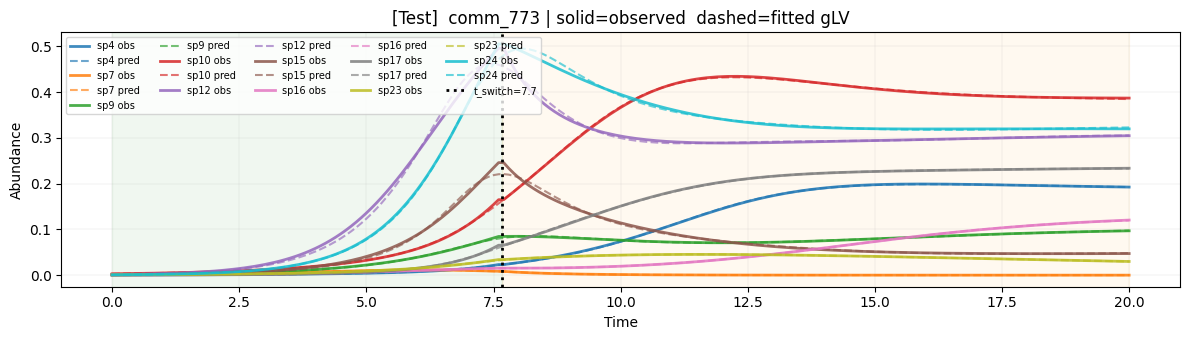

In [22]:
# =============================================================
# Cell 11 — Community trajectory overlays
# =============================================================

def plot_community_overlays(comms, X_obs, X_pred, mask, t_switch, timepoints, sp_cols,
                             n_plot=4, title_prefix=""):
    rng_p  = np.random.default_rng(99)
    picks  = rng_p.choice(len(comms), size=min(n_plot, len(comms)), replace=False)
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    for ki in picks:
        pres = np.where(mask[ki])[0]
        t_sw = t_switch[ki]

        fig, ax = plt.subplots(figsize=(12, 3.5))
        for si, sp_i in enumerate(pres):
            col = colors[si % len(colors)]
            ax.plot(timepoints, X_obs[ki, :, sp_i], "-",  lw=2.0, color=col,
                    label=f"{sp_cols[sp_i]} obs", alpha=0.85)
            ax.plot(timepoints, X_pred[ki, :, sp_i], "--", lw=1.5, color=col,
                    label=f"{sp_cols[sp_i]} pred", alpha=0.65)

        ax.axvline(t_sw, color="black", ls=":", lw=2, label=f"t_switch={t_sw:.1f}")
        ax.axvspan(0, t_sw, alpha=0.06, color="green")
        ax.axvspan(t_sw, timepoints[-1], alpha=0.06, color="orange")
        ax.set_xlabel("Time")
        ax.set_ylabel("Abundance")
        ax.set_title(f"{title_prefix}{comms[ki]} | solid=observed  dashed=fitted gLV")
        ax.legend(fontsize=7, ncol=min(len(pres), 5))
        ax.grid(True, lw=0.3, alpha=0.4)
        plt.tight_layout()
        plt.show()


plot_community_overlays(
    train_comms, X_tr, Xpred_tr, mask_tr, t_switch_tr,
    tp_lg, sp_cols_lg, n_plot=4, title_prefix="[Train] "
)
plot_community_overlays(
    test_comms, X_te, Xpred_te, mask_te, t_switch_te,
    tp_lg, sp_cols_lg, n_plot=4, title_prefix="[Test]  "
)

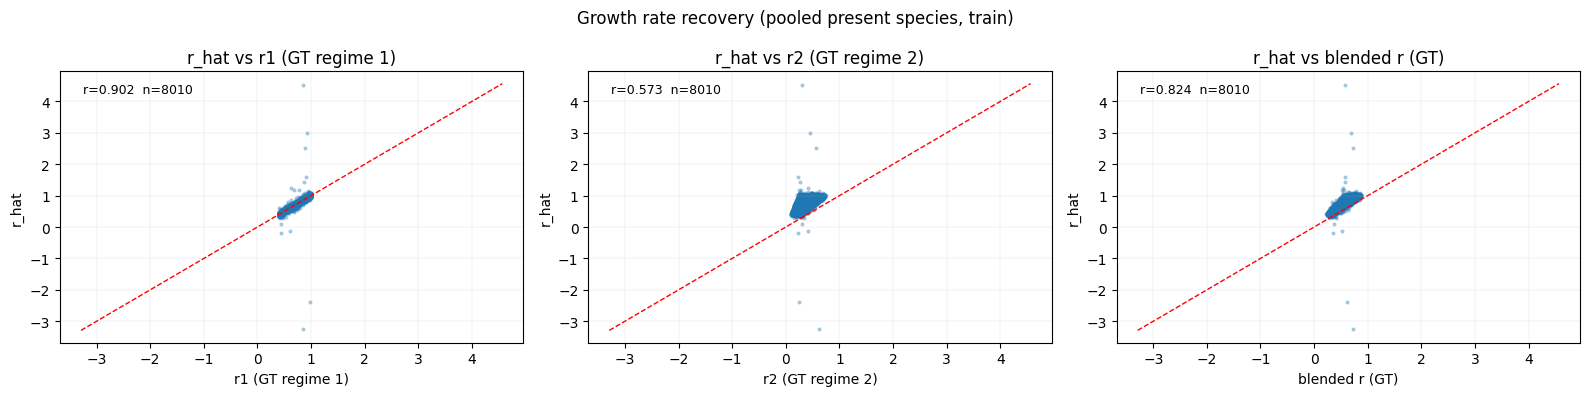

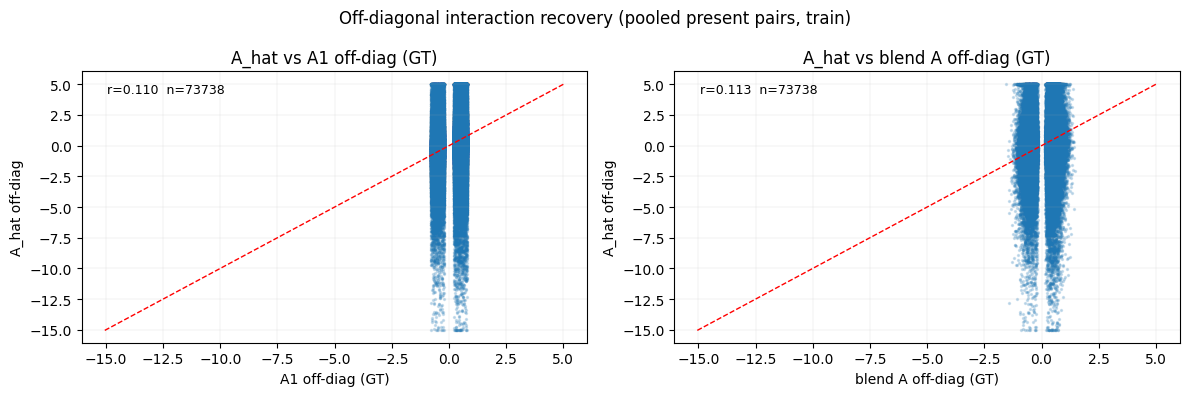

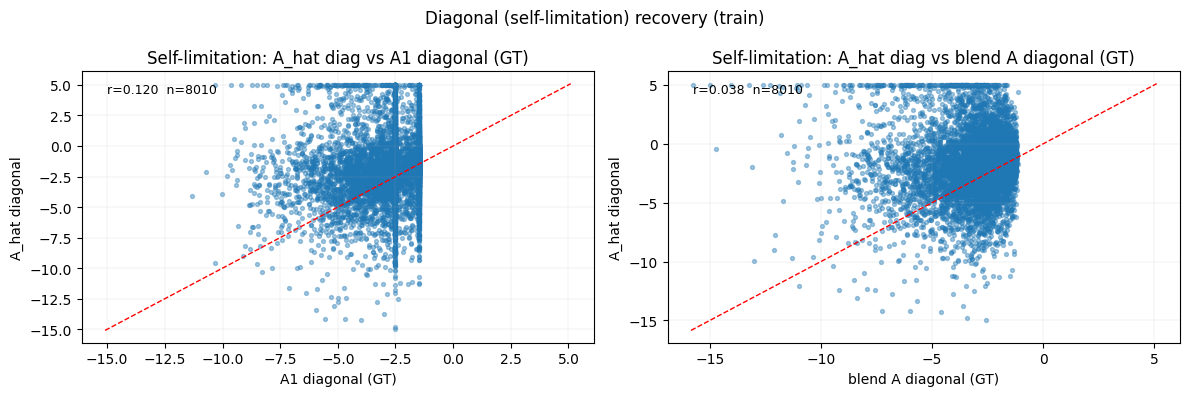

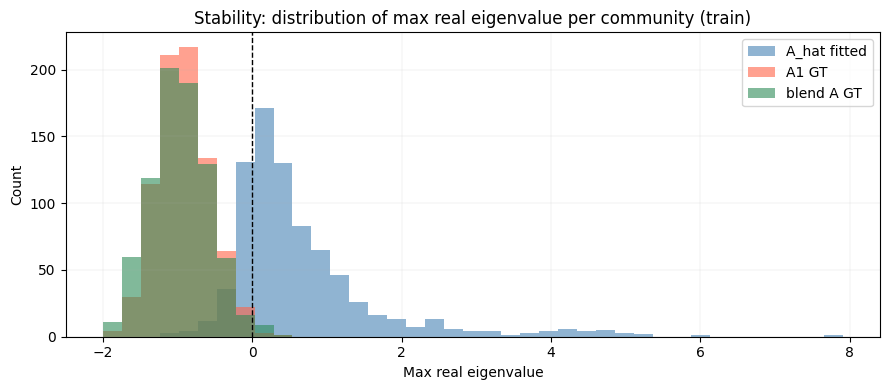

In [23]:
# =============================================================
# Cell 12 — Parameter comparison plots
# =============================================================

pm = param_tr   # use train set

# ── r scatter: r_hat vs r1, r2, blend ─────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for ax, gt_pool, gt_label in [
    (axes[0], pm["r1_pool"],    "r1 (GT regime 1)"),
    (axes[1], pm["r2_pool"],    "r2 (GT regime 2)"),
    (axes[2], pm["rblend_pool"], "blended r (GT)"),
]:
    ax.scatter(gt_pool, pm["r_hat_pool"], s=4, alpha=0.3)
    lo = min(gt_pool.min(), pm["r_hat_pool"].min()) - 0.05
    hi = max(gt_pool.max(), pm["r_hat_pool"].max()) + 0.05
    ax.plot([lo, hi], [lo, hi], "r--", lw=1)
    corr, _ = pearsonr(gt_pool, pm["r_hat_pool"])
    ax.text(0.05, 0.92, f"r={corr:.3f}  n={len(gt_pool)}",
            transform=ax.transAxes, fontsize=9)
    ax.set_xlabel(gt_label)
    ax.set_ylabel("r_hat")
    ax.set_title(f"r_hat vs {gt_label}")
    ax.grid(True, lw=0.3, alpha=0.4)
plt.suptitle("Growth rate recovery (pooled present species, train)", fontsize=12)
plt.tight_layout()
plt.show()


# ── A off-diagonal scatter ─────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, gt_pool, gt_label in [
    (axes[0], pm["a1_pool"],    "A1 off-diag (GT)"),
    (axes[1], pm["ablend_pool"], "blend A off-diag (GT)"),
]:
    ax.scatter(gt_pool, pm["a_hat_pool"], s=2, alpha=0.2)
    lo = min(gt_pool.min(), pm["a_hat_pool"].min()) - 0.05
    hi = max(gt_pool.max(), pm["a_hat_pool"].max()) + 0.05
    ax.plot([lo, hi], [lo, hi], "r--", lw=1)
    corr, _ = pearsonr(gt_pool, pm["a_hat_pool"])
    ax.text(0.05, 0.92, f"r={corr:.3f}  n={len(gt_pool)}",
            transform=ax.transAxes, fontsize=9)
    ax.set_xlabel(gt_label)
    ax.set_ylabel("A_hat off-diag")
    ax.set_title(f"A_hat vs {gt_label}")
    ax.grid(True, lw=0.3, alpha=0.4)
plt.suptitle("Off-diagonal interaction recovery (pooled present pairs, train)", fontsize=12)
plt.tight_layout()
plt.show()


# ── Diagonal A scatter ────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, gt_d, gt_label in [
    (axes[0], pm["adiag1"],    "A1 diagonal (GT)"),
    (axes[1], pm["adiag_blend"], "blend A diagonal (GT)"),
]:
    ax.scatter(gt_d, pm["adiag_hat"], s=8, alpha=0.4)
    lo = min(gt_d.min(), pm["adiag_hat"].min()) - 0.1
    hi = max(gt_d.max(), pm["adiag_hat"].max()) + 0.1
    ax.plot([lo, hi], [lo, hi], "r--", lw=1)
    corr, _ = pearsonr(gt_d, pm["adiag_hat"])
    ax.text(0.05, 0.92, f"r={corr:.3f}  n={len(gt_d)}",
            transform=ax.transAxes, fontsize=9)
    ax.set_xlabel(gt_label)
    ax.set_ylabel("A_hat diagonal")
    ax.set_title(f"Self-limitation: A_hat diag vs {gt_label}")
    ax.grid(True, lw=0.3, alpha=0.4)
plt.suptitle("Diagonal (self-limitation) recovery (train)", fontsize=12)
plt.tight_layout()
plt.show()


# ── Eigenvalue distributions ───────────────────────────────────
fig, ax = plt.subplots(figsize=(9, 4))
bins = np.linspace(
    min(pm["eigs_hat"].min(), pm["eigs_A1"].min()) - 0.1,
    max(pm["eigs_hat"].max(), pm["eigs_A1"].max()) + 0.1,
    40
)
ax.hist(pm["eigs_hat"],   bins=bins, alpha=0.6, label="A_hat fitted",   color="steelblue")
ax.hist(pm["eigs_A1"],    bins=bins, alpha=0.6, label="A1 GT",          color="tomato")
ax.hist(pm["eigs_blend"], bins=bins, alpha=0.6, label="blend A GT",     color="seagreen")
ax.axvline(0, color="k", lw=1, ls="--")
ax.set_xlabel("Max real eigenvalue")
ax.set_ylabel("Count")
ax.set_title("Stability: distribution of max real eigenvalue per community (train)")
ax.legend()
ax.grid(True, lw=0.3, alpha=0.4)
plt.tight_layout()
plt.show()

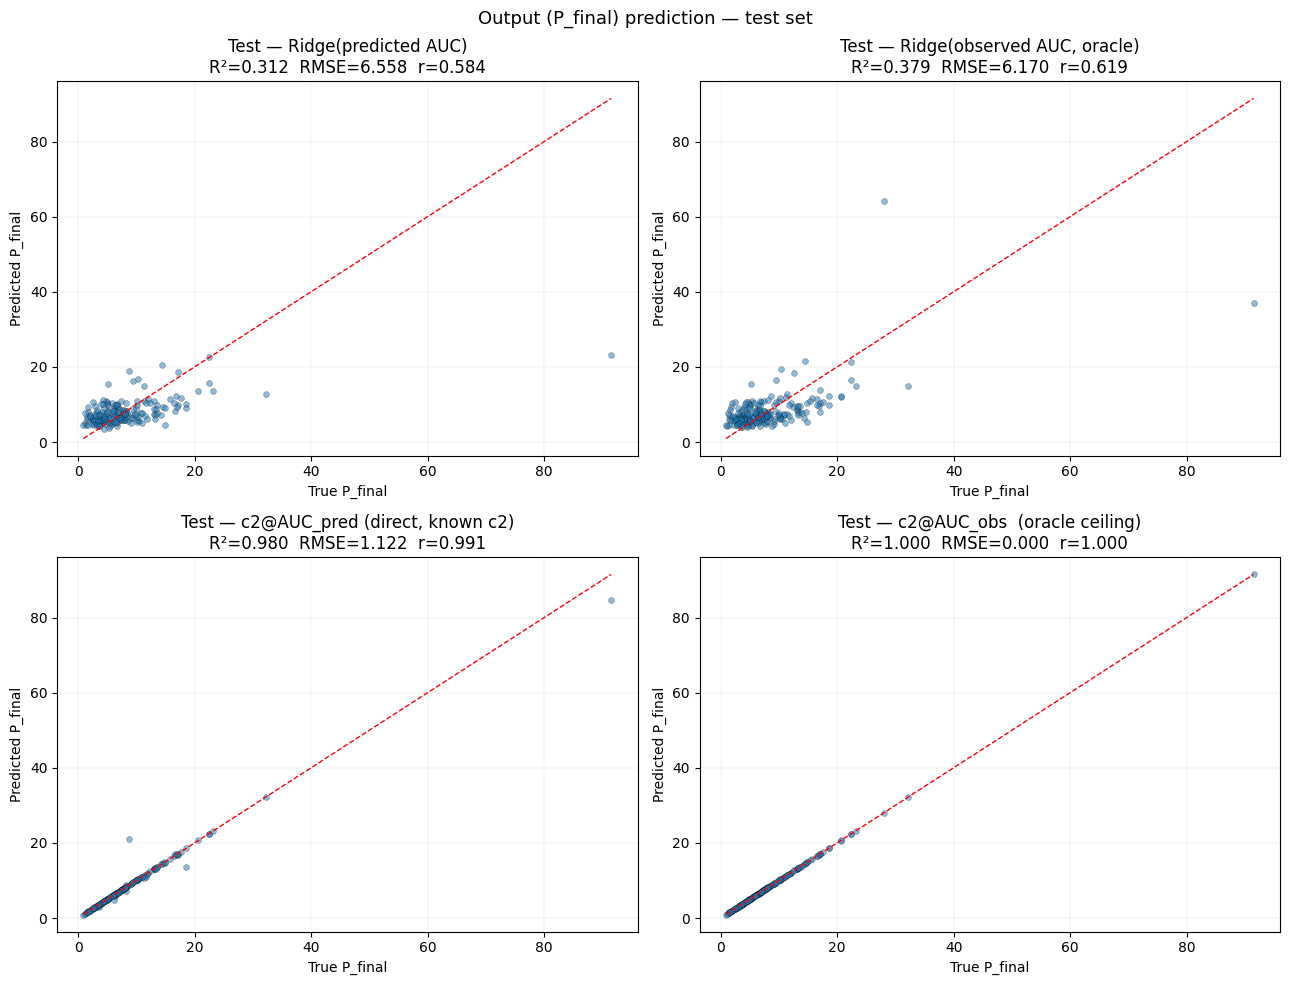

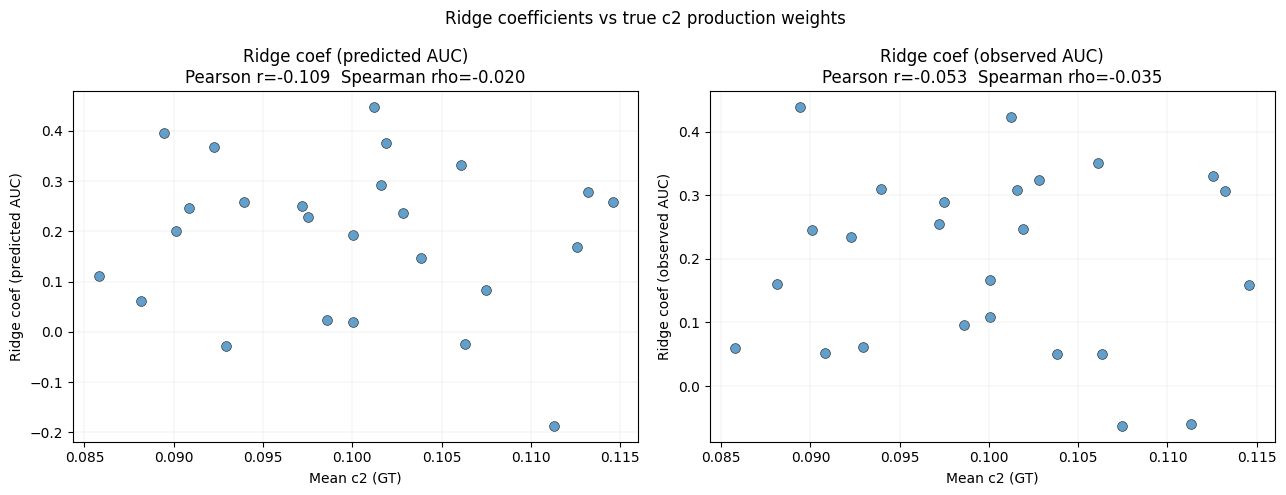

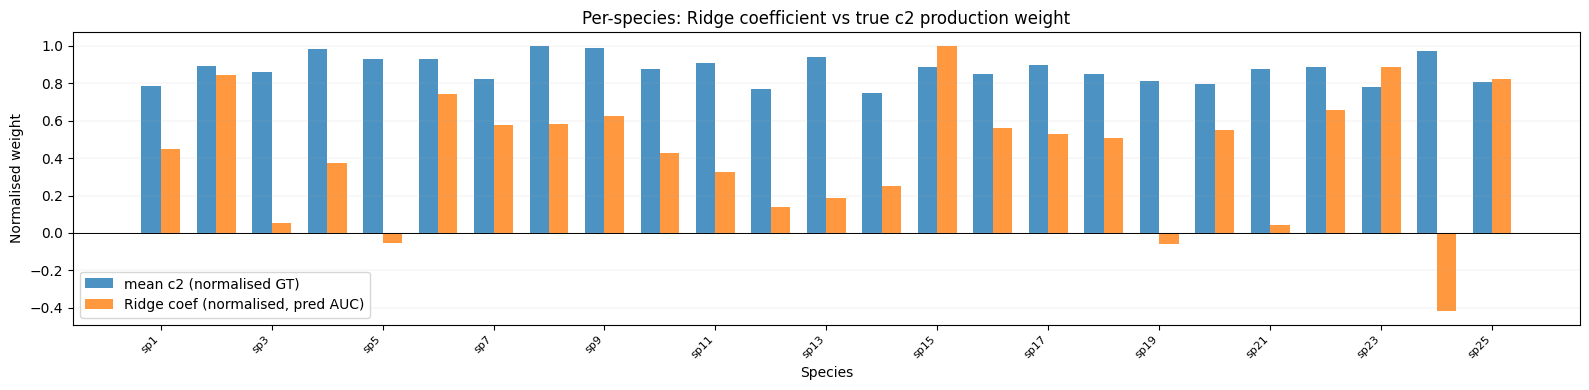

In [24]:
# =============================================================
# Cell 13 — Output prediction + c2 weight comparison plots
# =============================================================

sp_idx = np.arange(S_lg)

# ── Predicted vs true P_final ─────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(13, 10))

for ax, ev, label in [
    (axes[0,0], eval_te_pred,        "Test — Ridge(predicted AUC)"),
    (axes[0,1], eval_te_obs,         "Test — Ridge(observed AUC, oracle)"),
    (axes[1,0], eval_te_direct_pred, "Test — c2@AUC_pred (direct, known c2)"),
    (axes[1,1], eval_te_direct_obs,  "Test — c2@AUC_obs  (oracle ceiling)"),
]:
    ok = ev["valid"]
    ax.scatter(ev["y_true"][ok], ev["y_pred"][ok], s=18, alpha=0.5,
               edgecolors="k", lw=0.3)
    lo = min(ev["y_true"][ok].min(), ev["y_pred"][ok].min())
    hi = max(ev["y_true"][ok].max(), ev["y_pred"][ok].max())
    ax.plot([lo, hi], [lo, hi], "r--", lw=1)
    ax.set_xlabel("True P_final")
    ax.set_ylabel("Predicted P_final")
    ax.set_title(f"{label}\nR²={ev['r2']:.3f}  RMSE={ev['rmse']:.3f}  r={ev['pearson']:.3f}")
    ax.grid(True, lw=0.3, alpha=0.4)

plt.suptitle("Output (P_final) prediction — test set", fontsize=13)
plt.tight_layout()
plt.show()


# ── Ridge coef vs mean c2 scatter ─────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
for ax, coef, label in [
    (axes[0], ridge_coef,     "Ridge coef (predicted AUC)"),
    (axes[1], ridge_obs_coef, "Ridge coef (observed AUC)"),
]:
    ax.scatter(mean_c2_all, coef, s=50, alpha=0.7, edgecolors="k", lw=0.5)
    corr, _ = pearsonr(mean_c2_all, coef)
    sp_corr, _ = spearmanr(mean_c2_all, coef)
    ax.set_xlabel("Mean c2 (GT)")
    ax.set_ylabel(label)
    ax.set_title(f"{label}\nPearson r={corr:.3f}  Spearman rho={sp_corr:.3f}")
    ax.grid(True, lw=0.3, alpha=0.4)
plt.suptitle("Ridge coefficients vs true c2 production weights", fontsize=12)
plt.tight_layout()
plt.show()


# ── Per-species bar: coef vs c2 ────────────────────────────────
fig, ax = plt.subplots(figsize=(16, 4))
w_bar = 0.35
ax.bar(sp_idx - w_bar/2,
       mean_c2_all / (mean_c2_all.max() + 1e-9),
       width=w_bar, label="mean c2 (normalised GT)", alpha=0.8)
norm_coef = ridge_coef / (np.abs(ridge_coef).max() + 1e-9)
ax.bar(sp_idx + w_bar/2, norm_coef,
       width=w_bar, label="Ridge coef (normalised, pred AUC)", alpha=0.8)
ax.set_xticks(sp_idx[::2])
ax.set_xticklabels([sp_cols_lg[i] for i in range(0, S_lg, 2)],
                   rotation=45, ha="right", fontsize=8)
ax.axhline(0, color="k", lw=0.7)
ax.set_xlabel("Species")
ax.set_ylabel("Normalised weight")
ax.set_title("Per-species: Ridge coefficient vs true c2 production weight")
ax.legend()
ax.grid(True, axis="y", lw=0.3, alpha=0.4)
plt.tight_layout()
plt.show()

In [25]:
# =============================================================
# Cell 14 — Summary table
# =============================================================

pm = param_tr

rows = [
    # ── Trajectory fit ──
    ("Traj RMSE train (mean, present sp)",     f"{np.nanmean(traj_tr['rmse']):.4f}"),
    ("Traj RMSE test  (mean, present sp)",     f"{np.nanmean(traj_te['rmse']):.4f}"),
    ("Traj R²   train (mean, present sp)",     f"{np.nanmean(traj_tr['r2']):.4f}"),
    ("Traj R²   test  (mean, present sp)",     f"{np.nanmean(traj_te['r2']):.4f}"),
    ("Traj R² log train (mean)",               f"{np.nanmean(traj_tr['r2_log']):.4f}"),
    ("Traj R² log test  (mean)",               f"{np.nanmean(traj_te['r2_log']):.4f}"),
    # ── Parameter recovery ──
    ("r Pearson vs r1   (pooled present)",     f"{pm['r_vs_r1']['corr']:.4f}"),
    ("r Pearson vs r2   (pooled present)",     f"{pm['r_vs_r2']['corr']:.4f}"),
    ("r Pearson vs blend(pooled present)",     f"{pm['r_vs_blend']['corr']:.4f}"),
    ("r bias vs blend   (r_hat - truth)",      f"{pm['r_vs_blend']['bias']:+.4f}"),
    ("A off-diag Pearson vs A1",               f"{pm['A_off_vs_A1']['corr']:.4f}"),
    ("A off-diag Pearson vs blend",            f"{pm['A_off_vs_blend']['corr']:.4f}"),
    ("A diag Pearson vs A1",                   f"{pm['Adiag_vs_A1']['corr']:.4f}"),
    ("A diag Pearson vs blend",                f"{pm['Adiag_vs_blend']['corr']:.4f}"),
    ("A diag bias vs blend",                   f"{pm['Adiag_vs_blend']['bias']:+.4f}"),
    ("A off-diag sign agreement vs A1",        f"{pm['sa_A1']:.4f}"),
    ("A off-diag sign agreement vs blend",     f"{pm['sa_blend']:.4f}"),
    ("Max eigenvalue A_hat (mean)",            f"{pm['eigs_hat'].mean():.4f}"),
    ("Max eigenvalue A1    (mean)",            f"{pm['eigs_A1'].mean():.4f}"),
    # ── Output prediction ──
    ("Output R² train — Ridge(pred AUC)",      f"{eval_tr_pred['r2']:.4f}"),
    ("Output R² test  — Ridge(pred AUC)",      f"{eval_te_pred['r2']:.4f}"),
    ("Output R² train — Ridge(obs AUC oracle)",f"{eval_tr_obs['r2']:.4f}"),
    ("Output R² test  — Ridge(obs AUC oracle)",f"{eval_te_obs['r2']:.4f}"),
    ("Output R² train — c2@AUC_pred (direct)", f"{eval_tr_direct_pred['r2']:.4f}"),
    ("Output R² test  — c2@AUC_pred (direct)", f"{eval_te_direct_pred['r2']:.4f}"),
    ("Output R² train — c2@AUC_obs  (oracle)", f"{eval_tr_direct_obs['r2']:.4f}"),
    ("Output R² test  — c2@AUC_obs  (oracle)", f"{eval_te_direct_obs['r2']:.4f}"),
    # ── c2 weight recovery ──
    ("Ridge(pred) coef Pearson vs mean c2",    f"{corr_c2_pred:.4f}"),
    ("Ridge(obs)  coef Pearson vs mean c2",    f"{corr_c2_obs:.4f}"),
    ("Ridge(pred) coef Spearman vs mean c2",   f"{spear_c2_pred:.4f}"),
    ("Top-k producer accuracy (pred)",         f"{topk_pred:.4f}"),
    ("Top-k producer accuracy (obs)",          f"{topk_obs:.4f}"),
]

df_summary = pd.DataFrame(rows, columns=["Metric", "Value"])
print("=" * 70)
print("SUMMARY TABLE")
print("=" * 70)
print(df_summary.to_string(index=False))

SUMMARY TABLE
                                 Metric   Value
     Traj RMSE train (mean, present sp)  0.0351
     Traj RMSE test  (mean, present sp)  0.0194
     Traj R²   train (mean, present sp)  0.6527
     Traj R²   test  (mean, present sp)  0.8054
               Traj R² log train (mean)  0.9416
               Traj R² log test  (mean)  0.9758
     r Pearson vs r1   (pooled present)  0.9022
     r Pearson vs r2   (pooled present)  0.5729
     r Pearson vs blend(pooled present)  0.8241
      r bias vs blend   (r_hat - truth) +0.1819
               A off-diag Pearson vs A1  0.1098
            A off-diag Pearson vs blend  0.1131
                   A diag Pearson vs A1  0.1205
                A diag Pearson vs blend  0.0380
                   A diag bias vs blend +1.3581
        A off-diag sign agreement vs A1  0.5644
     A off-diag sign agreement vs blend  0.5644
            Max eigenvalue A_hat (mean)  0.6518
            Max eigenvalue A1    (mean) -0.9241
      Output R² train — Ri

In [26]:
# =============================================================
# SLIDE FIGURES — Cell A
# Shared style configuration
# Run this cell first, then each figure cell independently.
# =============================================================

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score

# ── Palette ───────────────────────────────────────────────────
C_OBS    = "#1B4F72"   # navy        — observed truth
C_FIT    = "#C0392B"   # crimson     — single gLV fit
C_PRE    = "#D5E8D4"   # pale green  — regime 1 shading
C_POST   = "#FFE6CC"   # pale peach  — regime 2 shading
C_SWITCH = "#6C3483"   # purple      — switch marker
C_ORACLE = "#117A65"   # teal        — oracle ceiling
C_ACCENT = "#E67E22"   # orange      — accent
C_GRID   = "#E0E0E0"
C_TEXT   = "#1A1A2E"

plt.rcParams.update({
    "font.family":       "DejaVu Sans",
    "axes.titleweight":  "bold",
    "axes.titlesize":    13,
    "axes.labelsize":    11,
    "axes.labelcolor":   C_TEXT,
    "xtick.labelsize":   9,
    "ytick.labelsize":   9,
    "xtick.color":       C_TEXT,
    "ytick.color":       C_TEXT,
    "axes.spines.top":   False,
    "axes.spines.right": False,
    "axes.facecolor":    "#FAFAFA",
    "figure.facecolor":  "white",
    "grid.color":        C_GRID,
    "grid.linewidth":    0.6,
    "legend.fontsize":   8,
    "legend.framealpha": 0.85,
})

def _identity_line(ax, pad=0.03):
    lo = min(ax.get_xlim()[0], ax.get_ylim()[0])
    hi = max(ax.get_xlim()[1], ax.get_ylim()[1])
    margin = (hi - lo) * pad
    ax.plot([lo - margin, hi + margin],
            [lo - margin, hi + margin],
            "--", color="#888888", lw=1.2, zorder=1)

print("Style config loaded.")

Style config loaded.


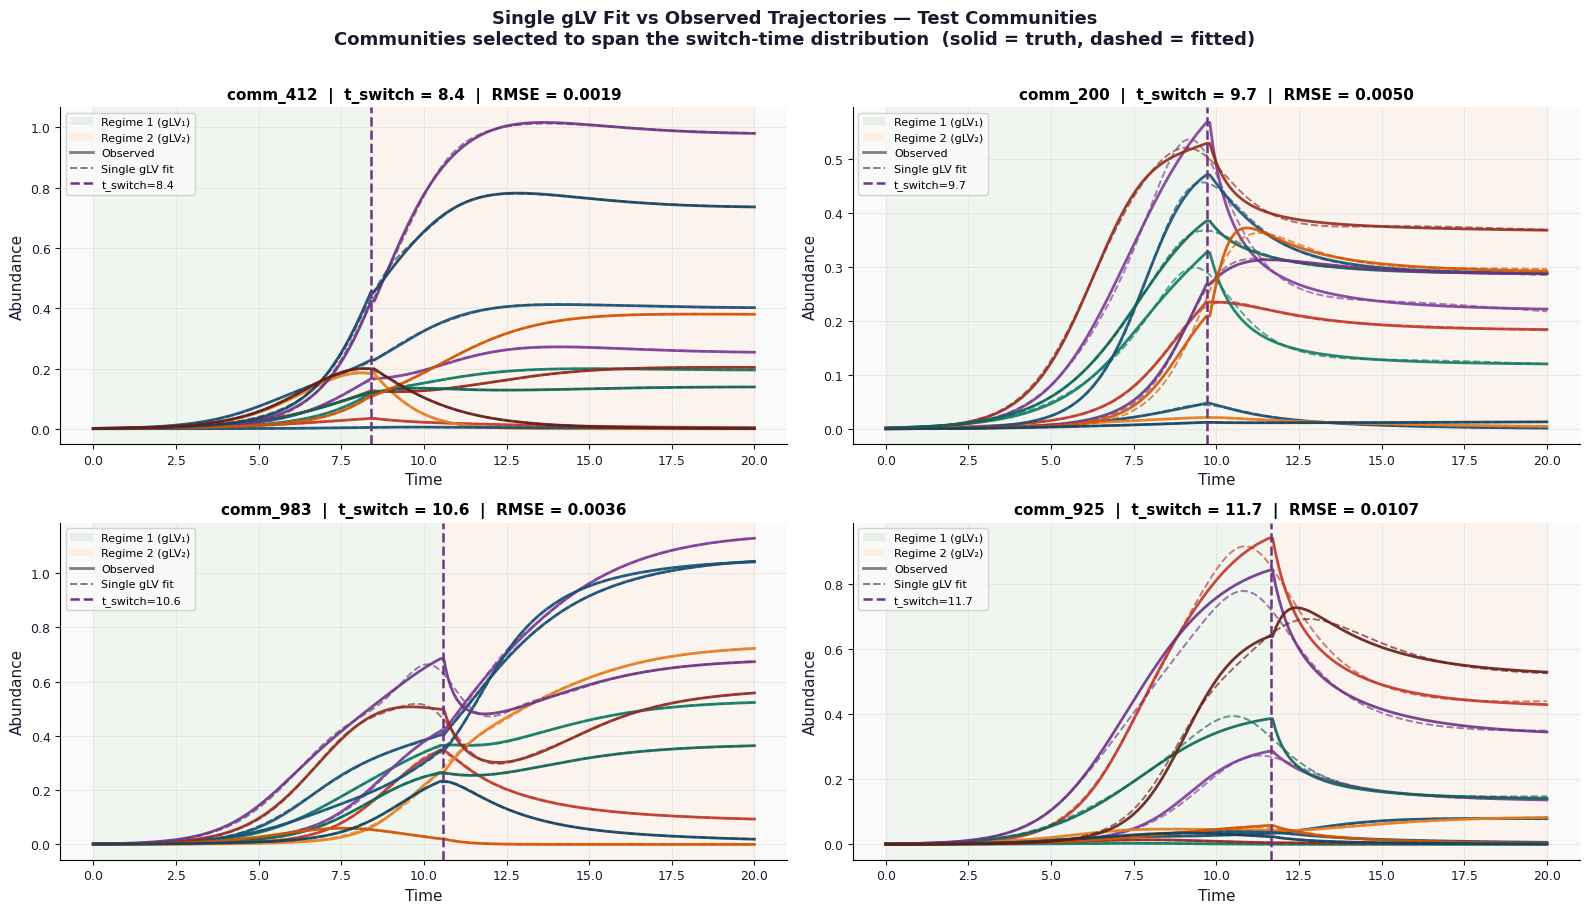

In [27]:
# =============================================================
# SLIDE FIGURE 1 — Example Community Trajectory Overlays
# 4 communities spanning the t_switch distribution.
# Solid = observed (ground truth), Dashed = single gLV fit.
# Green shading = Regime 1, Peach = Regime 2.
# =============================================================

def _pick_communities_by_tswitch(t_switch_arr, n=4, seed=77):
    """Return indices spanning the t_switch distribution (low→high)."""
    finite = np.where(np.isfinite(t_switch_arr))[0]
    quantiles = np.linspace(10, 90, n)
    picks, used = [], set()
    for q in quantiles:
        target = np.percentile(t_switch_arr[finite], q)
        for c in finite[np.argsort(np.abs(t_switch_arr[finite] - target))]:
            if c not in used:
                picks.append(int(c))
                used.add(int(c))
                break
    return picks


colors_sp = [
    "#1B4F72","#C0392B","#117A65","#7D3C98",
    "#E67E22","#1A5276","#922B21","#0E6655",
    "#6C3483","#D35400","#154360","#641E16",
]

picks = _pick_communities_by_tswitch(t_switch_te, n=4)

fig, axes = plt.subplots(2, 2, figsize=(16, 9))
axes = axes.ravel()

for panel_i, ki in enumerate(picks):
    ax = axes[panel_i]
    pres = np.where(mask_te[ki])[0]
    t_sw = t_switch_te[ki]
    comm = test_comms[ki]

    # Regime shading
    ax.axvspan(tp_lg[0], t_sw,      alpha=0.25, color=C_PRE,  zorder=0)
    ax.axvspan(t_sw,     tp_lg[-1], alpha=0.25, color=C_POST, zorder=0)
    ax.axvline(t_sw, color=C_SWITCH, lw=1.8, ls="--", zorder=3,
               label=f"t_switch = {t_sw:.1f}")

    for si, sp_i in enumerate(pres):
        col = colors_sp[si % len(colors_sp)]
        lbl_o = sp_cols_lg[sp_i] if si == 0 else "_"
        lbl_f = "gLV fit" if si == 0 else "_"
        ax.plot(tp_lg, X_te[ki, :, sp_i],
                "-",  lw=2.0, color=col, alpha=0.9,
                label="Observed" if si == 0 else "_")
        ax.plot(tp_lg, Xpred_te[ki, :, sp_i],
                "--", lw=1.4, color=col, alpha=0.65,
                label="Single gLV fit" if si == 0 else "_")

    # Per-community RMSE
    pres_obs  = X_te[ki, :, pres].ravel()
    pres_pred = Xpred_te[ki, :, pres].ravel()
    rmse_c = np.sqrt(np.mean((pres_pred - pres_obs)**2))

    ax.set_title(f"{comm}  |  t_switch = {t_sw:.1f}  |  RMSE = {rmse_c:.4f}",
                 fontsize=11)
    ax.set_xlabel("Time")
    ax.set_ylabel("Abundance")
    ax.grid(True, lw=0.5)

    legend_elements = [
        mpatches.Patch(facecolor=C_PRE,  alpha=0.5, label="Regime 1 (gLV₁)"),
        mpatches.Patch(facecolor=C_POST, alpha=0.5, label="Regime 2 (gLV₂)"),
        plt.Line2D([0],[0], color="grey",  lw=2.0, ls="-",  label="Observed"),
        plt.Line2D([0],[0], color="grey",  lw=1.4, ls="--", label="Single gLV fit"),
        plt.Line2D([0],[0], color=C_SWITCH,lw=1.8, ls="--", label=f"t_switch={t_sw:.1f}"),
    ]
    ax.legend(handles=legend_elements, loc="upper left", fontsize=8)

fig.suptitle(
    "Single gLV Fit vs Observed Trajectories — Test Communities\n"
    "Communities selected to span the switch-time distribution  "
    "(solid = truth, dashed = fitted)",
    fontsize=13, fontweight="bold", color=C_TEXT, y=1.01
)
plt.tight_layout()
plt.show()

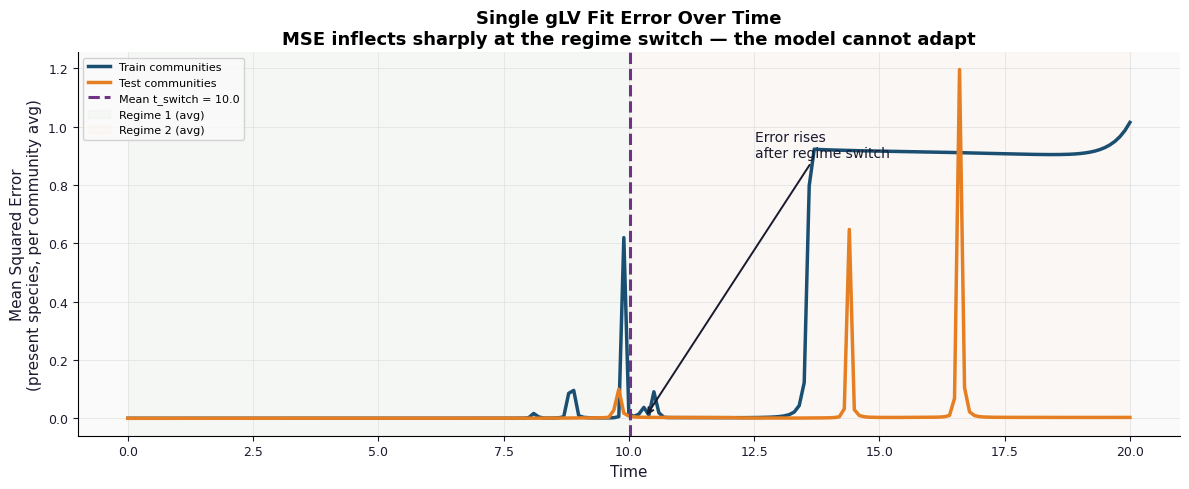

In [28]:
# =============================================================
# SLIDE FIGURE 2 — MSE vs Time  (the smoking gun)
# Shows single-gLV error inflecting at the regime switch.
# =============================================================

def mse_vs_time(X_obs, X_pred, mask, valid):
    K, T, S = X_obs.shape
    mse_t = np.zeros(T)
    count = 0
    for k in range(K):
        if not valid[k]:
            continue
        pres = np.where(mask[k])[0]
        diff = X_pred[k][:, pres] - X_obs[k][:, pres]
        mse_t += np.mean(diff**2, axis=1)
        count += 1
    return mse_t / max(count, 1)

mse_t_tr = mse_vs_time(X_tr, Xpred_tr, mask_tr, traj_tr["valid"])
mse_t_te = mse_vs_time(X_te, Xpred_te, mask_te, traj_te["valid"])

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(tp_lg, mse_t_tr, lw=2.5, color=C_OBS,   label="Train communities", zorder=3)
ax.plot(tp_lg, mse_t_te, lw=2.5, color=C_ACCENT, label="Test communities",  zorder=3)

mean_tsw = np.nanmean(np.concatenate([t_switch_tr, t_switch_te]))
ax.axvline(mean_tsw, color=C_SWITCH, lw=2.2, ls="--", zorder=4,
           label=f"Mean t_switch = {mean_tsw:.1f}")

# Shade the pre/post regions
ax.axvspan(tp_lg[0],   mean_tsw,   alpha=0.12, color=C_PRE,  zorder=0,
           label="Regime 1 (avg)")
ax.axvspan(mean_tsw,   tp_lg[-1],  alpha=0.12, color=C_POST, zorder=0,
           label="Regime 2 (avg)")

# Annotate the inflection
ax.annotate(
    "Error rises\nafter regime switch",
    xy=(mean_tsw + 0.3, mse_t_te[np.argmin(np.abs(tp_lg - (mean_tsw + 0.5)))]),
    xytext=(mean_tsw + 2.5, mse_t_te.max() * 0.75),
    arrowprops=dict(arrowstyle="->", color=C_TEXT, lw=1.4),
    fontsize=10, color=C_TEXT,
)

ax.set_xlabel("Time")
ax.set_ylabel("Mean Squared Error\n(present species, per community avg)")
ax.set_title(
    "Single gLV Fit Error Over Time\n"
    "MSE inflects sharply at the regime switch — the model cannot adapt",
    fontsize=13
)
ax.legend(loc="upper left")
ax.grid(True, lw=0.5)
plt.tight_layout()
plt.show()

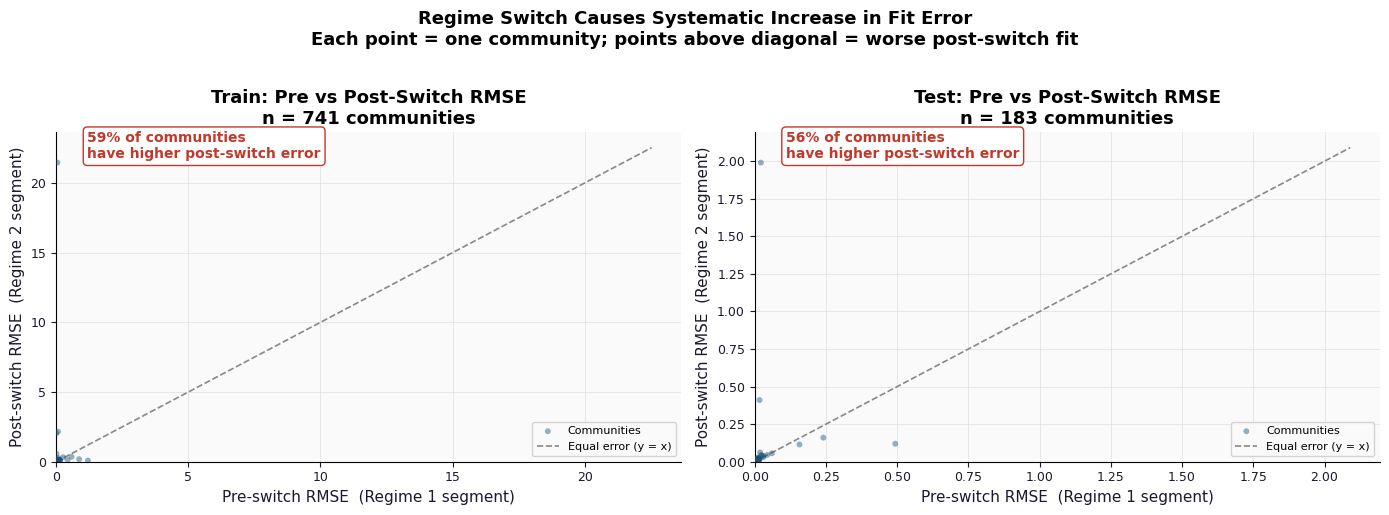

In [29]:
# =============================================================
# SLIDE FIGURE 3 — Pre vs Post-Switch RMSE (per community)
# Directly proves: post-switch error > pre-switch error.
# =============================================================

def pre_post_rmse(X_obs, X_pred, mask, t_switch, timepoints, valid):
    K = X_obs.shape[0]
    rmse_pre, rmse_post = [], []
    for k in range(K):
        if not valid[k] or not np.isfinite(t_switch[k]):
            continue
        pres   = np.where(mask[k])[0]
        t_sw   = t_switch[k]
        pre_m  = timepoints <= t_sw
        post_m = timepoints >  t_sw

        def _rmse(mask_t):
            if mask_t.sum() < 2:
                return np.nan
            o = X_obs[k][mask_t][:, pres].ravel()
            p = X_pred[k][mask_t][:, pres].ravel()
            return np.sqrt(np.mean((p - o)**2))

        rmse_pre.append(_rmse(pre_m))
        rmse_post.append(_rmse(post_m))
    return np.array(rmse_pre), np.array(rmse_post)

pre_tr, post_tr = pre_post_rmse(X_tr, Xpred_tr, mask_tr, t_switch_tr, tp_lg, traj_tr["valid"])
pre_te, post_te = pre_post_rmse(X_te, Xpred_te, mask_te, t_switch_te, tp_lg, traj_te["valid"])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, pre, post, split_label in [
    (axes[0], pre_tr, post_tr, "Train"),
    (axes[1], pre_te, post_te, "Test"),
]:
    ok = np.isfinite(pre) & np.isfinite(post)
    pre, post = pre[ok], post[ok]

    # Scatter
    ax.scatter(pre, post, s=18, alpha=0.45, color=C_OBS,
               edgecolors="none", zorder=3, label="Communities")

    # Identity line
    lim_hi = max(pre.max(), post.max()) * 1.05
    ax.plot([0, lim_hi], [0, lim_hi], "--", color="#888", lw=1.2,
            label="Equal error (y = x)")

    # Fraction above line
    frac_worse = np.mean(post > pre)
    ax.text(0.05, 0.92,
            f"{frac_worse*100:.0f}% of communities\nhave higher post-switch error",
            transform=ax.transAxes, fontsize=10,
            color=C_FIT, fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=C_FIT, lw=1))

    ax.set_xlabel("Pre-switch RMSE  (Regime 1 segment)")
    ax.set_ylabel("Post-switch RMSE  (Regime 2 segment)")
    ax.set_title(f"{split_label}: Pre vs Post-Switch RMSE\n"
                 f"n = {ok.sum()} communities")
    ax.set_xlim(left=0); ax.set_ylim(bottom=0)
    ax.legend(loc="lower right")
    ax.grid(True, lw=0.5)

fig.suptitle(
    "Regime Switch Causes Systematic Increase in Fit Error\n"
    "Each point = one community; points above diagonal = worse post-switch fit",
    fontsize=13, fontweight="bold", y=1.02
)
plt.tight_layout()
plt.show()

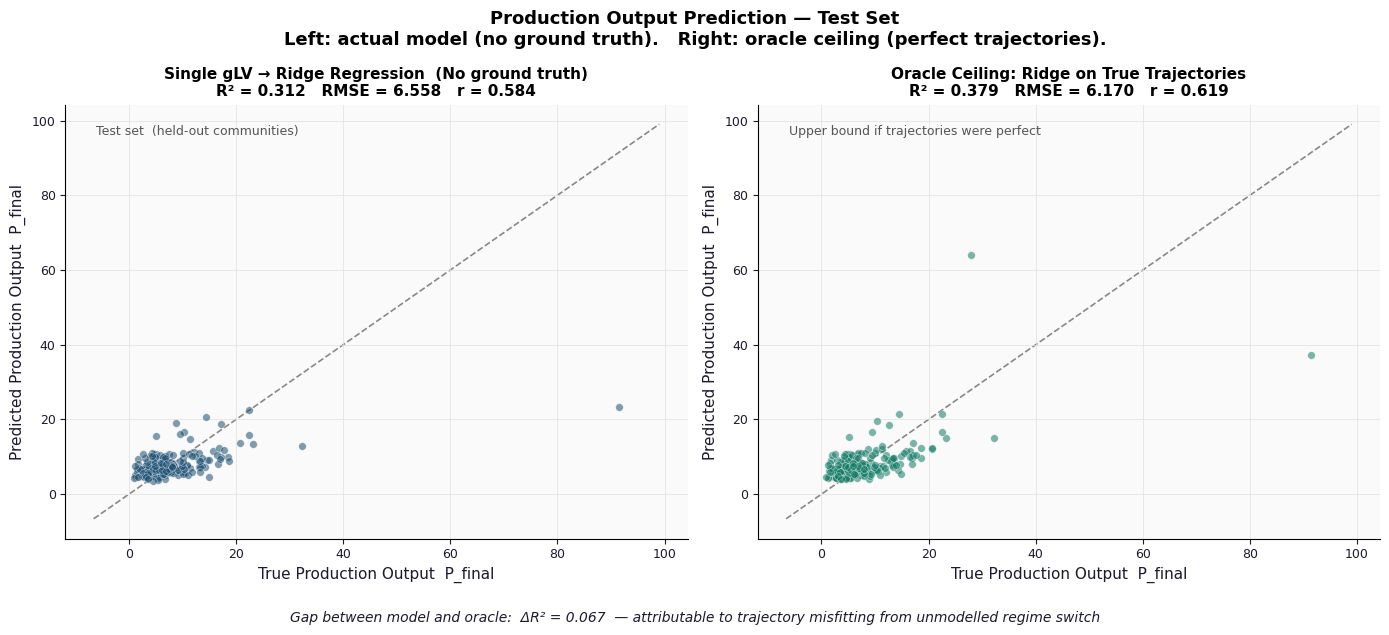

In [30]:
# =============================================================
# SLIDE FIGURE 4 — Output Prediction: the honest model
# Test set only. Ridge(predicted AUC) — no ground truth used.
# =============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ── Left: the actual model ────────────────────────────────────
ax = axes[0]
ev = eval_te_pred
ok = ev["valid"]
ax.scatter(ev["y_true"][ok], ev["y_pred"][ok],
           s=30, alpha=0.55, color=C_OBS,
           edgecolors="white", lw=0.4, zorder=3)
_identity_line(ax)
ax.set_xlabel("True Production Output  P_final")
ax.set_ylabel("Predicted Production Output  P_final")
ax.set_title(
    f"Single gLV → Ridge Regression  (No ground truth)\n"
    f"R² = {ev['r2']:.3f}   RMSE = {ev['rmse']:.3f}   r = {ev['pearson']:.3f}",
    fontsize=11
)
ax.grid(True, lw=0.5)
ax.text(0.05, 0.93, "Test set  (held-out communities)",
        transform=ax.transAxes, fontsize=9, color="#555")

# ── Right: oracle ceiling ─────────────────────────────────────
ax = axes[1]
ev_o = eval_te_obs
ok_o = ev_o["valid"]
ax.scatter(ev_o["y_true"][ok_o], ev_o["y_pred"][ok_o],
           s=30, alpha=0.55, color=C_ORACLE,
           edgecolors="white", lw=0.4, zorder=3)
_identity_line(ax)
ax.set_xlabel("True Production Output  P_final")
ax.set_ylabel("Predicted Production Output  P_final")
ax.set_title(
    f"Oracle Ceiling: Ridge on True Trajectories\n"
    f"R² = {ev_o['r2']:.3f}   RMSE = {ev_o['rmse']:.3f}   r = {ev_o['pearson']:.3f}",
    fontsize=11
)
ax.grid(True, lw=0.5)
ax.text(0.05, 0.93, "Upper bound if trajectories were perfect",
        transform=ax.transAxes, fontsize=9, color="#555")

# Gap annotation
delta_r2 = ev_o["r2"] - ev["r2"]
fig.text(0.5, -0.04,
         f"Gap between model and oracle:  ΔR² = {delta_r2:.3f}  "
         f"— attributable to trajectory misfitting from unmodelled regime switch",
         ha="center", fontsize=10, color=C_TEXT, style="italic")

fig.suptitle(
    "Production Output Prediction — Test Set\n"
    "Left: actual model (no ground truth).   Right: oracle ceiling (perfect trajectories).",
    fontsize=13, fontweight="bold"
)
plt.tight_layout()
plt.show()

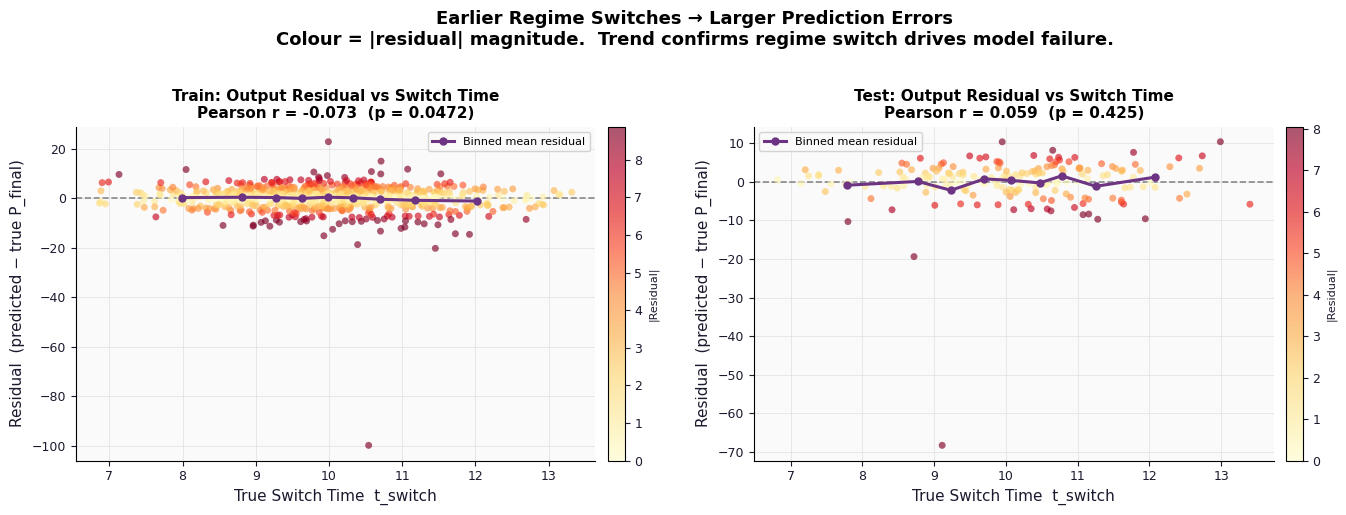

In [31]:
# =============================================================
# SLIDE FIGURE 5 — Residual Error vs t_switch
# Proves the regime switch CAUSES output prediction failure.
# =============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, ev, t_sw_arr, split_label in [
    (axes[0], eval_tr_pred, t_switch_tr, "Train"),
    (axes[1], eval_te_pred, t_switch_te, "Test"),
]:
    ok = ev["valid"] & np.isfinite(t_sw_arr)
    residuals = ev["y_pred"][ok] - ev["y_true"][ok]
    t_sw_ok   = t_sw_arr[ok]

    sc = ax.scatter(t_sw_ok, residuals,
                    c=np.abs(residuals), cmap="YlOrRd",
                    s=25, alpha=0.65, edgecolors="none",
                    vmin=0, vmax=np.percentile(np.abs(residuals), 95),
                    zorder=3)

    ax.axhline(0, color="#888", lw=1.2, ls="--")

    # Loess-style trend via binned means
    bins = np.percentile(t_sw_ok, np.linspace(0, 100, 10))
    bin_means_x, bin_means_y = [], []
    for b0, b1 in zip(bins[:-1], bins[1:]):
        m = (t_sw_ok >= b0) & (t_sw_ok < b1)
        if m.sum() > 2:
            bin_means_x.append(t_sw_ok[m].mean())
            bin_means_y.append(residuals[m].mean())
    if bin_means_x:
        ax.plot(bin_means_x, bin_means_y, "-o",
                color=C_SWITCH, lw=2.2, ms=5, zorder=4,
                label="Binned mean residual")

    cb = plt.colorbar(sc, ax=ax, pad=0.02)
    cb.set_label("|Residual|", fontsize=8)

    corr, pval = pearsonr(t_sw_ok, residuals)
    ax.set_xlabel("True Switch Time  t_switch")
    ax.set_ylabel("Residual  (predicted − true P_final)")
    ax.set_title(
        f"{split_label}: Output Residual vs Switch Time\n"
        f"Pearson r = {corr:.3f}  (p = {pval:.3g})",
        fontsize=11
    )
    ax.legend(fontsize=8)
    ax.grid(True, lw=0.5)

fig.suptitle(
    "Earlier Regime Switches → Larger Prediction Errors\n"
    "Colour = |residual| magnitude.  Trend confirms regime switch drives model failure.",
    fontsize=13, fontweight="bold", y=1.02
)
plt.tight_layout()
plt.show()

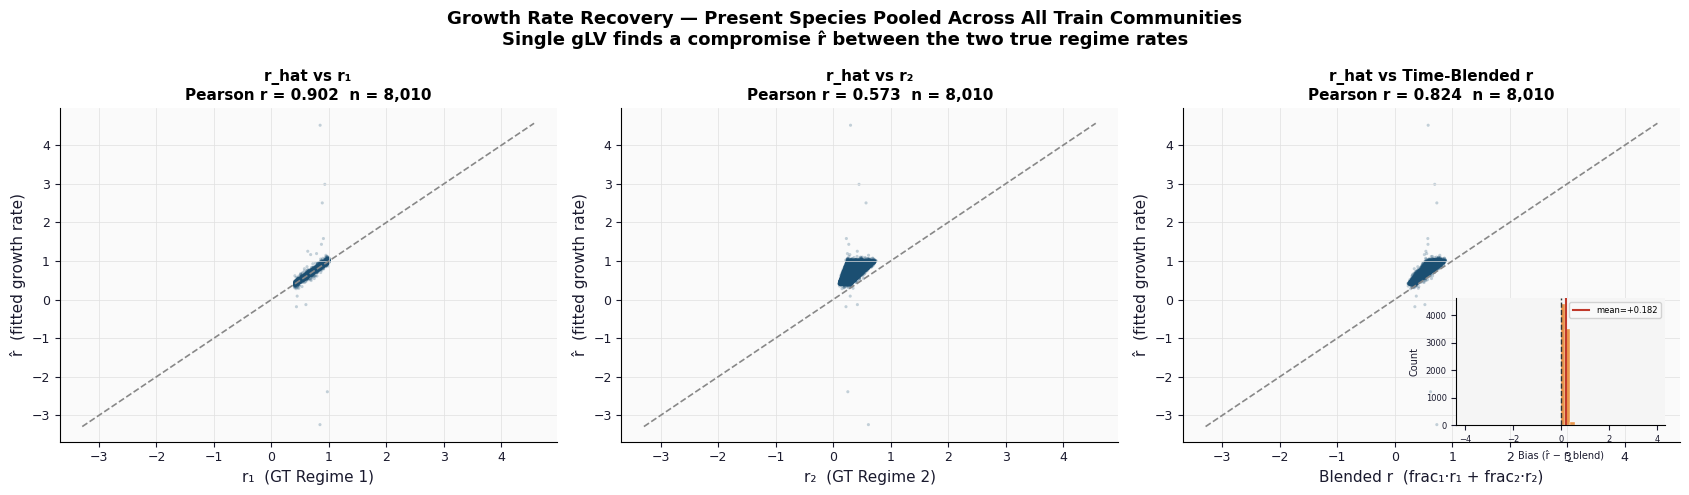

In [32]:
# =============================================================
# SLIDE FIGURE 6 — Parameter Recovery: r_hat lands between r1 and r2
# Shows the fitted gLV finds a compromise between the two regimes.
# =============================================================

pm = param_tr   # train-set parameter recovery dict

fig, axes = plt.subplots(1, 3, figsize=(17, 5))

panel_data = [
    (pm["r1_pool"],    "r₁  (GT Regime 1)", "r_hat vs r₁"),
    (pm["r2_pool"],    "r₂  (GT Regime 2)", "r_hat vs r₂"),
    (pm["rblend_pool"],"Blended r  (frac₁·r₁ + frac₂·r₂)", "r_hat vs Time-Blended r"),
]

for ax, (gt, xlabel, title) in zip(axes, panel_data):
    corr, _ = pearsonr(gt, pm["r_hat_pool"])
    ax.scatter(gt, pm["r_hat_pool"],
               s=5, alpha=0.25, color=C_OBS, edgecolors="none")
    lo = min(gt.min(), pm["r_hat_pool"].min()) - 0.05
    hi = max(gt.max(), pm["r_hat_pool"].max()) + 0.05
    ax.plot([lo, hi], [lo, hi], "--", color="#888", lw=1.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("r̂  (fitted growth rate)")
    ax.set_title(f"{title}\nPearson r = {corr:.3f}  "
                 f"n = {len(gt):,}", fontsize=11)
    ax.grid(True, lw=0.5)

# Bias histogram inset (bottom-right of last panel)
ax_h = axes[2].inset_axes([0.55, 0.05, 0.42, 0.38])
bias = pm["r_hat_pool"] - pm["rblend_pool"]
ax_h.hist(bias, bins=40, color=C_ACCENT, alpha=0.8, edgecolor="white", lw=0.3)
ax_h.axvline(0,             color="#333", lw=1.0, ls="--")
ax_h.axvline(bias.mean(),   color=C_FIT,  lw=1.5, ls="-",
             label=f"mean={bias.mean():+.3f}")
ax_h.set_xlabel("Bias (r̂ − r_blend)", fontsize=7)
ax_h.set_ylabel("Count", fontsize=7)
ax_h.tick_params(labelsize=6)
ax_h.legend(fontsize=6)
ax_h.set_facecolor("#F5F5F5")

fig.suptitle(
    "Growth Rate Recovery — Present Species Pooled Across All Train Communities\n"
    "Single gLV finds a compromise r̂ between the two true regime rates",
    fontsize=13, fontweight="bold"
)
plt.tight_layout()
plt.show()

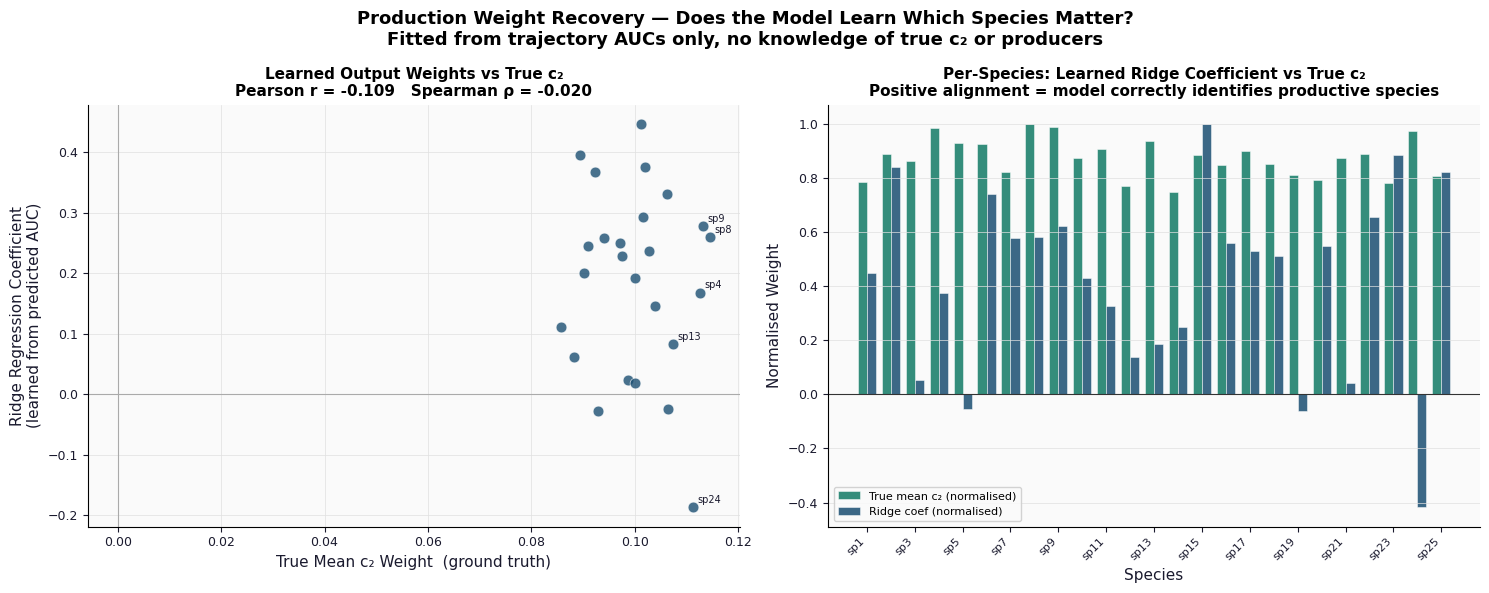

In [33]:
# =============================================================
# SLIDE FIGURE 7 — c2 Production Weight Recovery
# Ridge coefficients vs true mean c2 per species.
# Shows whether the model learns which species drive production.
# =============================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ── Left: scatter Ridge coef vs mean c2 ──────────────────────
ax = axes[0]
ax.scatter(mean_c2_all, ridge_coef,
           s=60, alpha=0.8, color=C_OBS,
           edgecolors="white", lw=0.5, zorder=3)

# Label the top-5 species by mean c2
top5 = np.argsort(-mean_c2_all)[:5]
for idx in top5:
    ax.annotate(sp_cols_lg[idx],
                xy=(mean_c2_all[idx], ridge_coef[idx]),
                xytext=(3, 3), textcoords="offset points",
                fontsize=7, color=C_TEXT)

corr_p, _ = pearsonr(mean_c2_all, ridge_coef)
corr_s, _ = spearmanr(mean_c2_all, ridge_coef)
ax.set_xlabel("True Mean c₂ Weight  (ground truth)")
ax.set_ylabel("Ridge Regression Coefficient\n(learned from predicted AUC)")
ax.set_title(
    f"Learned Output Weights vs True c₂\n"
    f"Pearson r = {corr_p:.3f}   Spearman ρ = {corr_s:.3f}",
    fontsize=11
)
ax.grid(True, lw=0.5)
ax.axhline(0, color="#aaa", lw=0.8)
ax.axvline(0, color="#aaa", lw=0.8)

# ── Right: per-species bar chart ──────────────────────────────
ax = axes[1]
sp_idx  = np.arange(S_lg)
norm_c2   = mean_c2_all / (mean_c2_all.max() + 1e-9)
norm_coef = ridge_coef  / (np.abs(ridge_coef).max() + 1e-9)

w = 0.38
bars1 = ax.bar(sp_idx - w/2, norm_c2,   width=w, label="True mean c₂ (normalised)",
               color=C_ORACLE, alpha=0.85, edgecolor="white", lw=0.4)
bars2 = ax.bar(sp_idx + w/2, norm_coef, width=w, label="Ridge coef (normalised)",
               color=C_OBS,   alpha=0.85, edgecolor="white", lw=0.4)

ax.axhline(0, color="#333", lw=0.8)
ax.set_xticks(sp_idx[::2])
ax.set_xticklabels([sp_cols_lg[i] for i in range(0, S_lg, 2)],
                   rotation=45, ha="right", fontsize=8)
ax.set_xlabel("Species")
ax.set_ylabel("Normalised Weight")
ax.set_title(
    "Per-Species: Learned Ridge Coefficient vs True c₂\n"
    "Positive alignment = model correctly identifies productive species",
    fontsize=11
)
ax.legend()
ax.grid(True, axis="y", lw=0.5)

fig.suptitle(
    "Production Weight Recovery — Does the Model Learn Which Species Matter?\n"
    "Fitted from trajectory AUCs only, no knowledge of true c₂ or producers",
    fontsize=13, fontweight="bold"
)
plt.tight_layout()
plt.show()

In [34]:
# =============================================================
# SLIDE FIGURE 8 — Summary Metrics Table  (styled)
# Clean numerical summary of all key results.
# =============================================================

import pandas as pd

pm = param_tr

summary_data = [
    # Section headers use bold in display
    ("── TRAJECTORY FIT ──",                    "",          ""),
    ("Train RMSE  (mean, present species)",      f"{np.nanmean(traj_tr['rmse']):.4f}",   "↓ better"),
    ("Test  RMSE  (mean, present species)",      f"{np.nanmean(traj_te['rmse']):.4f}",   "↓ better"),
    ("Train R²    (mean, present species)",      f"{np.nanmean(traj_tr['r2']):.4f}",     "↑ better"),
    ("Test  R²    (mean, present species)",      f"{np.nanmean(traj_te['r2']):.4f}",     "↑ better"),
    ("Train R²  log-space",                      f"{np.nanmean(traj_tr['r2_log']):.4f}", "↑ better"),
    ("Test  R²  log-space",                      f"{np.nanmean(traj_te['r2_log']):.4f}", "↑ better"),

    ("── PARAMETER RECOVERY (train, pooled) ──", "",         ""),
    ("r̂  Pearson vs r₁",                        f"{pm['r_vs_r1']['corr']:.4f}",          "correlation"),
    ("r̂  Pearson vs r₂",                        f"{pm['r_vs_r2']['corr']:.4f}",          "correlation"),
    ("r̂  Pearson vs blend r",                   f"{pm['r_vs_blend']['corr']:.4f}",       "correlation"),
    ("r̂  bias vs blend r",                      f"{pm['r_vs_blend']['bias']:+.4f}",      "≈0 ideal"),
    ("A off-diag Pearson vs A₁",                f"{pm['A_off_vs_A1']['corr']:.4f}",      "correlation"),
    ("A off-diag sign agreement vs A₁",         f"{pm['sa_A1']:.4f}",                    "↑ better"),
    ("Max eigenvalue Â  (mean)",                 f"{pm['eigs_hat'].mean():.4f}",          "≤0 = stable"),
    ("Max eigenvalue A₁ (mean)",                 f"{pm['eigs_A1'].mean():.4f}",           "≤0 = stable"),

    ("── OUTPUT PREDICTION (test set) ──",       "",         ""),
    ("Ridge(pred AUC)   R²",                    f"{eval_te_pred['r2']:.4f}",             "actual model"),
    ("Ridge(pred AUC)   RMSE",                  f"{eval_te_pred['rmse']:.4f}",           "actual model"),
    ("Ridge(pred AUC)   Pearson r",             f"{eval_te_pred['pearson']:.4f}",        "actual model"),
    ("Ridge(obs AUC)    R²  [oracle ceiling]",  f"{eval_te_obs['r2']:.4f}",             "upper bound"),
    ("Gap  (oracle − model)  ΔR²",
        f"{eval_te_obs['r2'] - eval_te_pred['r2']:+.4f}",                               "trajectory loss"),

    ("── c₂ WEIGHT RECOVERY ──",                "",         ""),
    ("Ridge coef Pearson vs mean c₂",           f"{corr_c2_pred:.4f}",                  "correlation"),
    ("Ridge coef Spearman ρ vs mean c₂",        f"{spear_c2_pred:.4f}",                 "correlation"),
    ("Top-k producer accuracy",                 f"{topk_pred:.4f}",                     "↑ better"),
]

df_summ = pd.DataFrame(summary_data, columns=["Metric", "Value", "Note"])

# Print cleanly
print("=" * 72)
print(f"{'METRIC':<50}  {'VALUE':>10}  {'NOTE'}")
print("=" * 72)
for _, row in df_summ.iterrows():
    if row["Value"] == "":
        print(f"\n{row['Metric']}")
        print("-" * 72)
    else:
        print(f"  {row['Metric']:<48}  {row['Value']:>10}  {row['Note']}")
print("=" * 72)

METRIC                                                   VALUE  NOTE

── TRAJECTORY FIT ──
------------------------------------------------------------------------
  Train RMSE  (mean, present species)                   0.0351  ↓ better
  Test  RMSE  (mean, present species)                   0.0194  ↓ better
  Train R²    (mean, present species)                   0.6527  ↑ better
  Test  R²    (mean, present species)                   0.8054  ↑ better
  Train R²  log-space                                   0.9416  ↑ better
  Test  R²  log-space                                   0.9758  ↑ better

── PARAMETER RECOVERY (train, pooled) ──
------------------------------------------------------------------------
  r̂  Pearson vs r₁                                     0.9022  correlation
  r̂  Pearson vs r₂                                     0.5729  correlation
  r̂  Pearson vs blend r                                0.8241  correlation
  r̂  bias vs blend r                                  

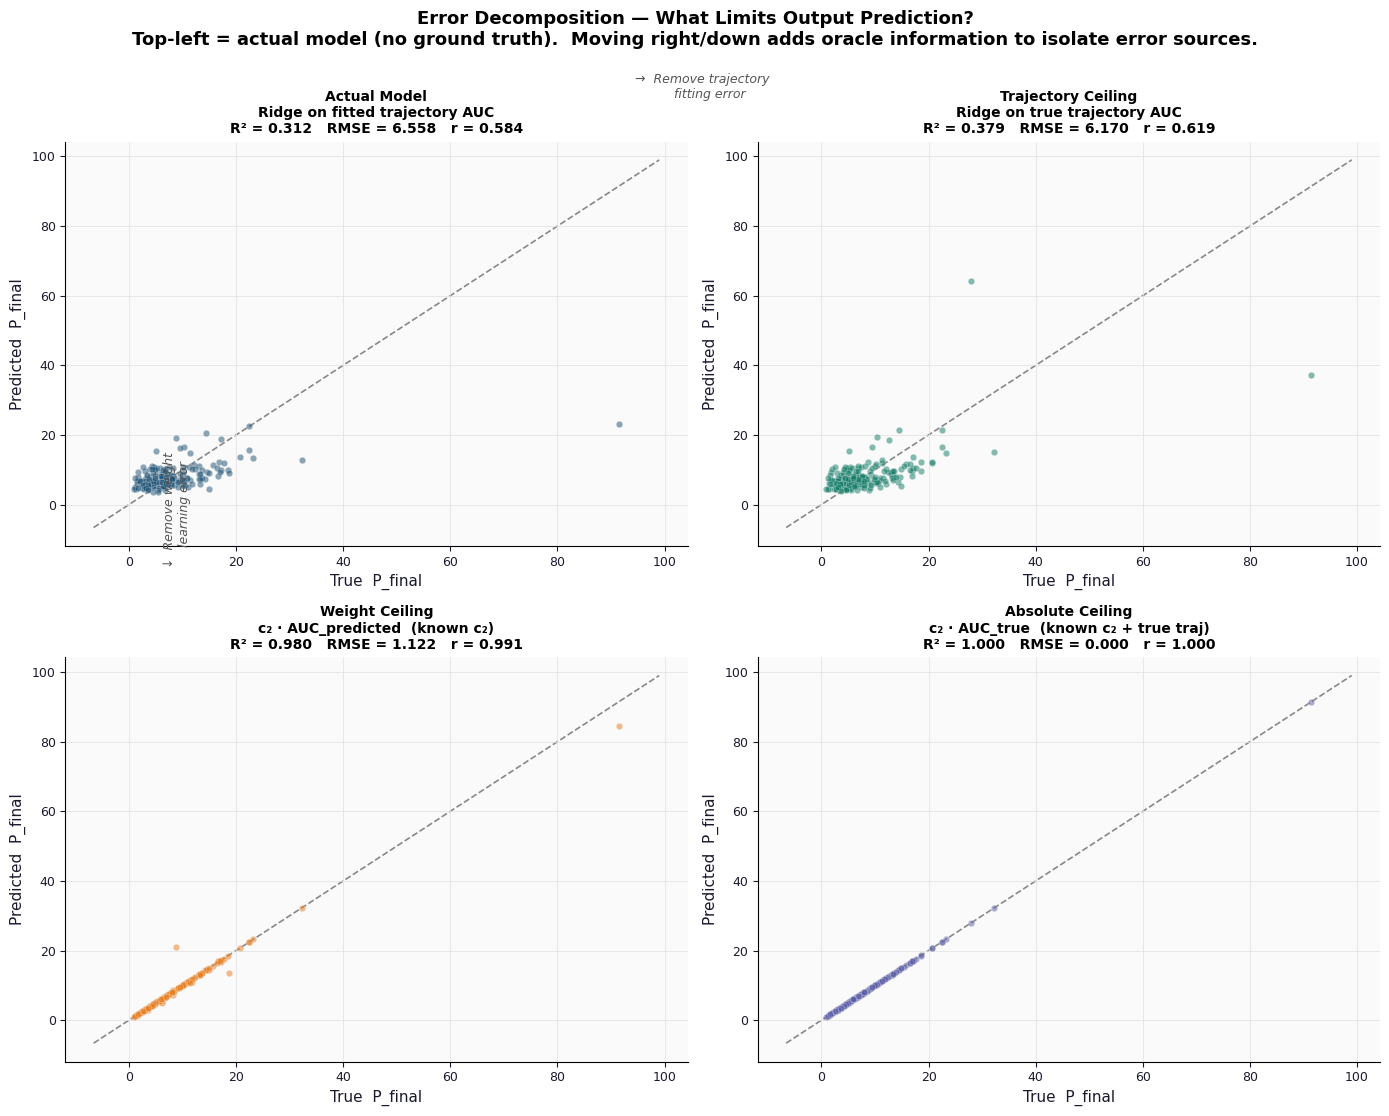

In [35]:
# =============================================================
# SLIDE FIGURE 9 — Error Decomposition: 4-panel ceiling analysis
# Shows the full hierarchy: model → trajectory ceiling → absolute ceiling
# =============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 11))

panel_cfg = [
    (eval_te_pred,        C_OBS,    "Actual Model\nRidge on fitted trajectory AUC"),
    (eval_te_obs,         C_ORACLE, "Trajectory Ceiling\nRidge on true trajectory AUC"),
    (eval_te_direct_pred, C_ACCENT, "Weight Ceiling\nc₂ · AUC_predicted  (known c₂)"),
    (eval_te_direct_obs,  "#5B5EA6","Absolute Ceiling\nc₂ · AUC_true  (known c₂ + true traj)"),
]

for ax, (ev, col, label) in zip(axes.ravel(), panel_cfg):
    ok = ev["valid"]
    ax.scatter(ev["y_true"][ok], ev["y_pred"][ok],
               s=22, alpha=0.5, color=col,
               edgecolors="white", lw=0.3, zorder=3)
    _identity_line(ax)
    ax.set_xlabel("True  P_final")
    ax.set_ylabel("Predicted  P_final")
    ax.set_title(
        f"{label}\nR² = {ev['r2']:.3f}   RMSE = {ev['rmse']:.3f}   r = {ev['pearson']:.3f}",
        fontsize=10
    )
    ax.grid(True, lw=0.5)

fig.suptitle(
    "Error Decomposition — What Limits Output Prediction?\n"
    "Top-left = actual model (no ground truth).  "
    "Moving right/down adds oracle information to isolate error sources.",
    fontsize=13, fontweight="bold", y=1.01
)

# Add arrow annotations between panels
fig.text(0.505, 0.93,  "→  Remove trajectory\n    fitting error",
         ha="center", fontsize=9, color="#555", style="italic")
fig.text(0.13,  0.505, "↓  Remove weight\n   learning error",
         ha="center", fontsize=9, color="#555", style="italic", rotation=90)

plt.tight_layout()
plt.show()

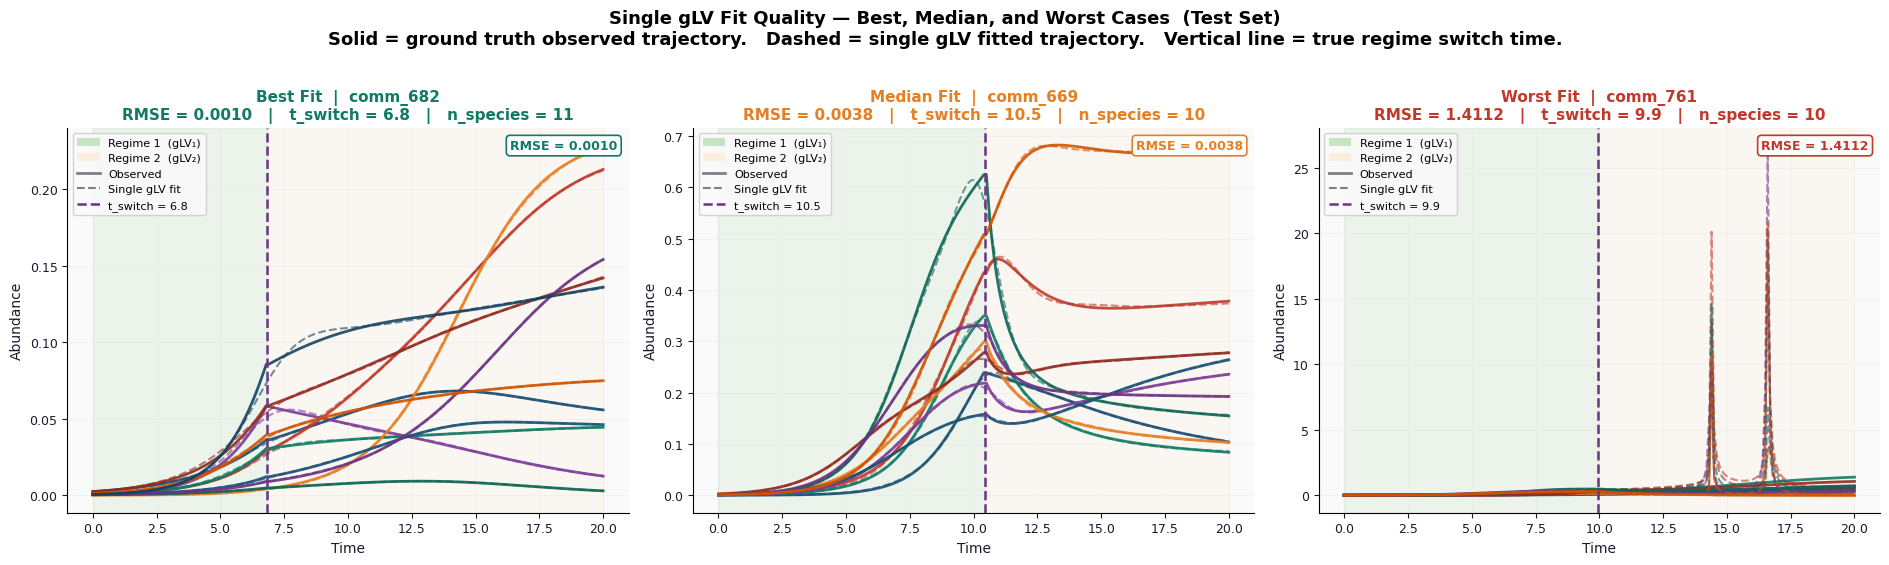

Best  community:     comm_682  RMSE=0.000971  t_switch=6.82
Median community:     comm_669  RMSE=0.003815  t_switch=10.46
Worst community:     comm_761  RMSE=1.411174  t_switch=9.95

Median RMSE across all valid test communities: 0.003815


In [39]:
# =============================================================
# SLIDE FIGURE — Observed vs Fitted: Mean, Best, Worst
# Selects 3 representative communities from the test set:
#   BEST    = lowest RMSE (single gLV fits well)
#   MEAN    = closest to median RMSE
#   WORST   = highest RMSE (single gLV fails badly)
# Each panel: all present species, solid=observed, dashed=fitted
# Regime shading + t_switch marked.
# =============================================================

# ── Compute per-community RMSE on test set ────────────────────
rmse_te_all = np.full(len(test_comms), np.nan)
for k in range(len(test_comms)):
    if not traj_te["valid"][k]:
        continue
    pres = np.where(mask_te[k])[0]
    o = X_te[k][:, pres].ravel()
    p = Xpred_te[k][:, pres].ravel()
    rmse_te_all[k] = np.sqrt(np.mean((p - o)**2))

ok_mask = np.isfinite(rmse_te_all)
ok_idx  = np.where(ok_mask)[0]

median_rmse = np.nanmedian(rmse_te_all)

best_ki  = ok_idx[np.argmin(rmse_te_all[ok_idx])]
worst_ki = ok_idx[np.argmax(rmse_te_all[ok_idx])]
mean_ki  = ok_idx[np.argmin(np.abs(rmse_te_all[ok_idx] - median_rmse))]

picks    = [best_ki, mean_ki, worst_ki]
labels   = ["Best Fit", "Median Fit", "Worst Fit"]
title_colors = ["#117A65", "#E67E22", "#C0392B"]

colors_sp = [
    "#1B4F72","#C0392B","#117A65","#7D3C98",
    "#E67E22","#1A5276","#922B21","#0E6655",
    "#6C3483","#D35400","#154360","#641E16",
]

fig, axes = plt.subplots(1, 3, figsize=(19, 5.5))

for ax, ki, panel_label, tcol in zip(axes, picks, labels, title_colors):
    pres = np.where(mask_te[ki])[0]
    t_sw = t_switch_te[ki]
    comm = test_comms[ki]
    rmse = rmse_te_all[ki]

    # Regime shading
    ax.axvspan(tp_lg[0], t_sw,      alpha=0.18, color="#A8D5A2", zorder=0)
    ax.axvspan(t_sw,     tp_lg[-1], alpha=0.18, color="#FFE6CC", zorder=0)
    ax.axvline(t_sw, color=C_SWITCH, lw=1.8, ls="--", zorder=3)

    for si, sp_i in enumerate(pres):
        col = colors_sp[si % len(colors_sp)]
        ax.plot(tp_lg, X_te[ki, :, sp_i],
                "-",  lw=2.0, color=col, alpha=0.90,
                label="Observed" if si == 0 else "_")
        ax.plot(tp_lg, Xpred_te[ki, :, sp_i],
                "--", lw=1.5, color=col, alpha=0.60,
                label="Single gLV fit" if si == 0 else "_")

    # Legend elements
    legend_elements = [
        mpatches.Patch(facecolor="#A8D5A2", alpha=0.6, label="Regime 1  (gLV₁)"),
        mpatches.Patch(facecolor="#FFE6CC", alpha=0.6, label="Regime 2  (gLV₂)"),
        plt.Line2D([0],[0], color="grey", lw=2.0, ls="-",  label="Observed"),
        plt.Line2D([0],[0], color="grey", lw=1.5, ls="--", label="Single gLV fit"),
        plt.Line2D([0],[0], color=C_SWITCH, lw=1.8, ls="--",
                   label=f"t_switch = {t_sw:.1f}"),
    ]
    ax.legend(handles=legend_elements, loc="upper left", fontsize=8)

    ax.set_xlabel("Time", fontsize=10)
    ax.set_ylabel("Abundance", fontsize=10)
    ax.set_title(
        f"{panel_label}  |  {comm}\n"
        f"RMSE = {rmse:.4f}   |   t_switch = {t_sw:.1f}   |   "
        f"n_species = {len(pres)}",
        fontsize=11, fontweight="bold", color=tcol
    )
    ax.grid(True, lw=0.4, alpha=0.5)

    # Annotate RMSE rank in corner
    ax.text(0.98, 0.97, f"RMSE = {rmse:.4f}",
            transform=ax.transAxes, fontsize=9,
            ha="right", va="top", color=tcol, fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=tcol, lw=1.2))

fig.suptitle(
    "Single gLV Fit Quality — Best, Median, and Worst Cases  (Test Set)\n"
    "Solid = ground truth observed trajectory.   "
    "Dashed = single gLV fitted trajectory.   "
    "Vertical line = true regime switch time.",
    fontsize=13, fontweight="bold", y=1.02
)
plt.tight_layout()
plt.show()

# Print summary
print(f"Best  community: {test_comms[best_ki]:>12}  RMSE={rmse_te_all[best_ki]:.6f}  "
      f"t_switch={t_switch_te[best_ki]:.2f}")
print(f"Median community: {test_comms[mean_ki]:>12}  RMSE={rmse_te_all[mean_ki]:.6f}  "
      f"t_switch={t_switch_te[mean_ki]:.2f}")
print(f"Worst community: {test_comms[worst_ki]:>12}  RMSE={rmse_te_all[worst_ki]:.6f}  "
      f"t_switch={t_switch_te[worst_ki]:.2f}")
print(f"\nMedian RMSE across all valid test communities: {median_rmse:.6f}")

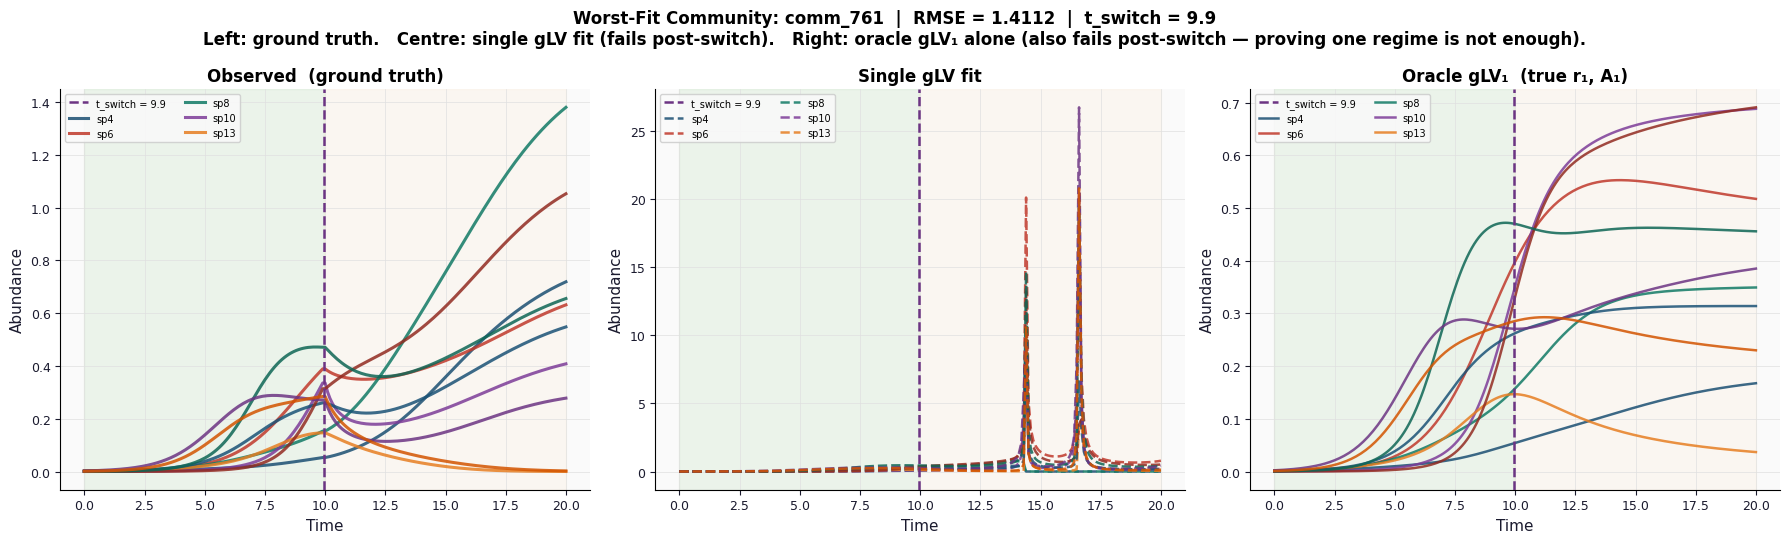

In [40]:
# =============================================================
# NEW FIGURE A — Worst-community divergence closeup
# Observed vs single gLV fit vs oracle gLV1 vs oracle gLV2
# =============================================================

worst_ki = ok_idx[np.argmax(rmse_te_all[ok_idx])]
comm     = test_comms[worst_ki]
pres     = np.where(mask_te[worst_ki])[0]
t_sw     = t_switch_te[worst_ki]

# Simulate oracle trajectories using ground truth params
r1_c = r1_te[worst_ki, pres]
A1_c = A1_te[worst_ki][np.ix_(pres, pres)]
r2_c = r2_te[worst_ki, pres]
A2_c = A2_te[worst_ki][np.ix_(pres, pres)]
x0_c = x0_te[worst_ki, pres]
S_sub = len(pres)

X_oracle1 = predict_one(x0_te[worst_ki], tp_lg, r1_c, A1_c, pres, S_lg)
X_oracle2 = predict_one(x0_te[worst_ki], tp_lg, r2_c, A2_c, pres, S_lg)

fig, axes = plt.subplots(1, 3, figsize=(18, 5.5), sharey=False)
panel_pairs = [
    (X_te[worst_ki],     "Observed  (ground truth)",      C_OBS,    "-",  2.2),
    (Xpred_te[worst_ki], "Single gLV fit",                C_FIT,    "--", 1.8),
    (X_oracle1,          "Oracle gLV₁  (true r₁, A₁)",   "#117A65", "-",  1.8),
]

colors_sp = [
    "#1B4F72","#C0392B","#117A65","#7D3C98",
    "#E67E22","#1A5276","#922B21","#0E6655",
    "#6C3483","#D35400","#154360","#641E16",
]

for ax, (X_show, panel_title, base_col, ls, lw) in zip(axes, panel_pairs):
    ax.axvspan(tp_lg[0], t_sw,      alpha=0.18, color="#A8D5A2", zorder=0)
    ax.axvspan(t_sw,     tp_lg[-1], alpha=0.18, color="#FFE6CC", zorder=0)
    ax.axvline(t_sw, color=C_SWITCH, lw=1.8, ls="--", zorder=3,
               label=f"t_switch = {t_sw:.1f}")

    for si, sp_i in enumerate(pres):
        col = colors_sp[si % len(colors_sp)]
        ax.plot(tp_lg, X_show[:, sp_i],
                ls, lw=lw, color=col, alpha=0.85,
                label=sp_cols_lg[sp_i] if si < 5 else "_")

    ax.set_title(panel_title, fontsize=12, fontweight="bold")
    ax.set_xlabel("Time")
    ax.set_ylabel("Abundance")
    ax.legend(fontsize=7, ncol=2, loc="upper left")
    ax.grid(True, lw=0.5)

fig.suptitle(
    f"Worst-Fit Community: {comm}  |  RMSE = {rmse_te_all[worst_ki]:.4f}  |  t_switch = {t_sw:.1f}\n"
    "Left: ground truth.   Centre: single gLV fit (fails post-switch).   "
    "Right: oracle gLV₁ alone (also fails post-switch — proving one regime is not enough).",
    fontsize=12, fontweight="bold"
)
plt.tight_layout()
plt.show()

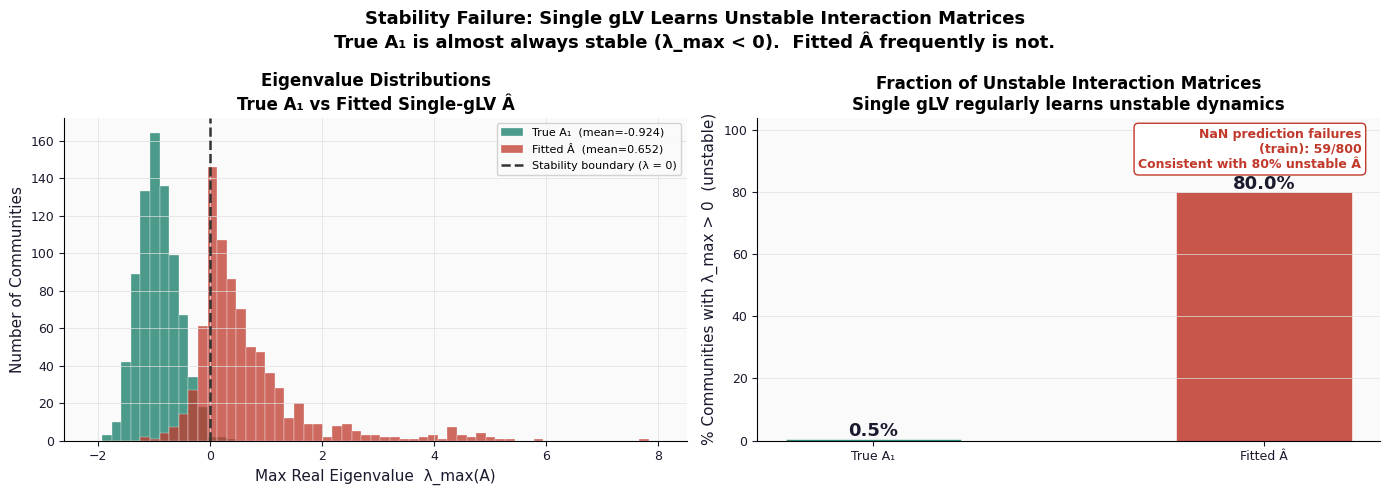

In [41]:
# =============================================================
# NEW FIGURE B — Max eigenvalue distribution: Â vs A₁
# Single gLV learns unstable interaction matrices
# =============================================================

# Compute max real eigenvalue per community (present-species submatrix)
def max_real_eig_per_community(A_all, mask):
    eigs = []
    for k in range(A_all.shape[0]):
        pres = np.where(mask[k])[0]
        A_sub = A_all[k][np.ix_(pres, pres)]
        ev = np.linalg.eigvals(A_sub)
        eigs.append(np.max(ev.real))
    return np.array(eigs)

eigs_hat_tr = max_real_eig_per_community(A_hat_tr, mask_tr)
eigs_A1_tr  = max_real_eig_per_community(A1_ord[idx_tr], mask_tr)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ── Left: overlapping histograms ──────────────────────────────
ax = axes[0]
bins = np.linspace(
    min(eigs_hat_tr.min(), eigs_A1_tr.min()) - 0.2,
    max(eigs_hat_tr.max(), eigs_A1_tr.max()) + 0.2,
    60
)
ax.hist(eigs_A1_tr,  bins=bins, color=C_ORACLE, alpha=0.75,
        label=f"True A₁  (mean={eigs_A1_tr.mean():.3f})", edgecolor="white", lw=0.3)
ax.hist(eigs_hat_tr, bins=bins, color=C_FIT,    alpha=0.75,
        label=f"Fitted Â  (mean={eigs_hat_tr.mean():.3f})", edgecolor="white", lw=0.3)
ax.axvline(0, color="#333", lw=1.8, ls="--", zorder=4, label="Stability boundary (λ = 0)")
ax.set_xlabel("Max Real Eigenvalue  λ_max(A)")
ax.set_ylabel("Number of Communities")
ax.set_title("Eigenvalue Distributions\nTrue A₁ vs Fitted Single-gLV Â", fontsize=12)
ax.legend()
ax.grid(True, lw=0.5)

# ── Right: fraction unstable bar + annotation ─────────────────
ax = axes[1]
frac_unstable_hat = np.mean(eigs_hat_tr > 0)
frac_unstable_A1  = np.mean(eigs_A1_tr  > 0)

bars = ax.bar(
    ["True A₁", "Fitted Â"],
    [frac_unstable_A1 * 100, frac_unstable_hat * 100],
    color=[C_ORACLE, C_FIT], alpha=0.85, edgecolor="white", lw=0.5, width=0.45
)
for bar, frac in zip(bars, [frac_unstable_A1, frac_unstable_hat]):
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_height() + 1.0,
            f"{frac*100:.1f}%", ha="center", fontsize=13, fontweight="bold", color=C_TEXT)

ax.set_ylabel("% Communities with λ_max > 0  (unstable)")
ax.set_title("Fraction of Unstable Interaction Matrices\nSingle gLV regularly learns unstable dynamics", fontsize=12)
ax.set_ylim(0, max(frac_unstable_hat, frac_unstable_A1) * 100 * 1.3)
ax.grid(True, axis="y", lw=0.5)

# Annotation box
n_failed_tr = (~traj_tr["valid"]).sum()
ax.text(0.97, 0.97,
        f"NaN prediction failures\n(train): {n_failed_tr}/800\n"
        f"Consistent with {frac_unstable_hat*100:.0f}% unstable Â",
        transform=ax.transAxes, fontsize=9, va="top", ha="right",
        color=C_FIT, fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.35", fc="white", ec=C_FIT, lw=1.0))

fig.suptitle(
    "Stability Failure: Single gLV Learns Unstable Interaction Matrices\n"
    "True A₁ is almost always stable (λ_max < 0).  Fitted Â frequently is not.",
    fontsize=13, fontweight="bold"
)
plt.tight_layout()
plt.show()